# Fiducial settings for sampling / optimization + SINF vs SNF

### Setup

In [2]:
import sys
sys.path.insert(1, '/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
from jax.scipy.stats import uniform
import chaospy
from nfmc_jax.sinf.RQspline import kde
import torch
from scipy.special import loggamma
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

In [60]:
def t2a(tens): return tens.numpy().astype(np.float64)
def a2t(arr): return torch.from_numpy(arr.astype(np.float32))
def sample_qmodel_1d(qmodel,N,Z=1,dim=0):
    samples,qvalues = qmodel.sample(N,device='cpu')
    #sample n samples
    samples = samples[:,dim]
    #use the sinf kde implementation - should use Scott's rule with no bwfactor
    kdeq = kde(samples)
    def fkde(x):
        return t2a(kdeq(a2t(x)))*Z
    return fkde,samples

def sample_gaussian(N,mean,cov,seed=seed):
    g1 = n_mvn.rvs(mean=mean,cov=cov,size=N,random_state=seed)
    return np.atleast_2d(g1)

def double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2,seed=seed):
    g1 = n_mvn.rvs(mean=mean1,cov=cov1,size=int(N*w1),random_state=seed)
    g2 = n_mvn.rvs(mean=mean2,cov=cov2,size=int(N*(1-w1)),random_state=seed)
    return np.concatenate([np.atleast_2d(g1),np.atleast_2d(g2)])

def sample_truth_1d(N,mean,cov,dim=0):
    mean,cov = np.asarray(mean),np.asarray(cov)
    samples = sample_gaussian(N,mean,cov)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def double_sample_truth_1d(N,w1,mean1,mean2,cov1,cov2,dim=0):
    mean1,mean2,cov1,cov2 = np.asarray(mean1),np.asarray(mean2),np.asarray(cov1),np.asarray(cov2)
    samples = double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def log_1d_normal(x,mu=0,sigma=1,n=1):
    return -1/2*( n*np.log(2*np.pi) + sigma + ((x-mu)/sigma)**2 )

def plot_1d_uncorrelated(trace,low,high,n,n_1d=1000,beta_idx=None,sig_scale=1/10):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    mu_truth,sigma_truth = jnp.zeros(n),sig_scale*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(sample_truth_1d(n_1d,mu_truth,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1) # just to suppress noise in kde since all the same in uncorrelated...
#     plt.plot(samples[0]['q{0}'.format(beta_idx)],np.exp(logp[0]['q{0}'.format(beta_idx)]),ls=' ',marker='.')
    plt.axvline(0,ls='--',c='k')
    plt.show()
    return 0

def plot_1d_double(trace,low,high,n,n_1d=1000,beta_idx=None,w1=0.3,mu1_diag=0.625, mu2_diag=-0.325,sig_scale=1/10,sig_scale_12=1/2):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    sigma_truth = sig_scale*jnp.ones(n)
    mu1_truth,mu2_truth = mu1_diag*jnp.ones(n),mu2_diag*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(double_sample_truth_1d(n_1d,w1,mu1_truth,mu2_truth,sigma_truth*sig_scale_12,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1)
    plt.axvline(mu1_diag,ls='--',c='k')
    plt.axvline(mu2_diag,ls='--',c='k')
    plt.show()
    return 0

def log_like_ducg(x ,w1=0.3,mu1=0.625 ,mu2=-0.325 ,sig_scale=1/10,sig_scale_12=1/2):
    n=x.shape[-1]
    w2=1-w1
    log_like1 = log_like_ucg(x,mu_diag=mu1,sig_scale=sig_scale*sig_scale_12) #make first narrower like before
    log_like2 = log_like_ucg(x,mu_diag=mu2,sig_scale=sig_scale)
    return  logsumexp(jnp.array([jnp.log(w1) + log_like1, jnp.log(w2) + log_like2]), axis=0)

def log_like_ucg(x,mu_diag=0,sig_scale=1/10):
    n=x.shape[-1]
    mu,sigma = mu_diag*jnp.ones(n),sig_scale*jnp.ones(n)
    return -0.5 * jnp.log((2 * jnp.pi)**n * jnp.prod(sigma** 2) ) - 0.5 * jnp.dot((x - mu)**2 , (1/ (2 * sigma ** 2)))

In [4]:
def plot_corr_gd(trace,Cov,Ngd=1000,beta_idx=None):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    truth = n_mvn.rvs(mean=np.zeros(n),cov=Cov,size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True)
    plt.show()
    
def plot_corr_grv(trace,Ngd=1000,beta_idx=None):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    #sample double gaussian
    truth = np.concatenate([n_mvn.rvs(mean=mu1_grv,cov=1,size=int(Ngd*2/3)),
                           n_mvn.rvs(mean=mu2_grv,cov=1,size=int(Ngd*1/3))])
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    print(beta_idx)
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True)
    plt.savefig('grv_test_fid_v0.png',facecolor='white')
    plt.show()
    
def plot_opt_gd(trace,opt_func,low,up,Ngd=1000,beta_idx=None):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    #for truth, evaluate on sobol points and apply weights
    sobol = np.atleast_2d(chaospy.Iid(chaospy.Uniform(lower=low,upper=up),n).sample(Ngd,rule='sobol')).T
    truth = np.array([np.exp(opt_func(n,sobol[i])) for i in range(Ngd)]) #obviously this will be slow
    truth_gd = MCSamples(samples=sobol, weights=truth, names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True)
    plt.show()


In [74]:
#a place to put the common settings to declutter the below but still be transparent
def run_nfo(log_like,log_prior,
    n, #number of sobol points
    low=-1.,
    high=1.,
    knots=None,
    knots_trainable=5,
    bw=1.,
    rel_bw=1,
    layers=5,
    ktrunc=jnp.inf,
    t_ess=0.7,
    beta_max=1.5,
    rel_beta=0.5,
    frac_rel_beta_AF = 1,
    alpha_w = (0,0),
    alpha_uw = (0,0),
    latent_sigma=2.4/(2**2),  #FIXME put this in the code as default
    use_latent_beta2=False,
    use_pq_beta_IW1=False, 
    top_verbose=True,
    verbose=False,
    trainable_qw=True,
    sgd_steps=10,
    gamma=0,
    optimize_directions=False,
    logp_cut=0,
    train_updates=False,
    a=1,
    b=1,
    c=1,
    d=1):
    
    n_prior = 10*n
    n0=n_prior
    N=n_prior
    aN=int(2*N*a)
    bN=n*b
    cN=n*c
    dN=n*d
    if(n<6):
        latent_sigma=1
    else:
        latent_sigma*=((n)**(-1/2))
    dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
    bounds=np.array([low*np.ones(n),high*np.ones(n)])
    init_prior=dist1d
    init_prior = np.atleast_2d(dist1d.sample(n_prior+1,rule='sobol')).T[1:] #drop first (0,0) sample because cheating
    trace = nfmc_jax.infer_nfomc(log_like, log_prior, jnp.array(init_prior), 
                             log_prior_args=((jnp.array([low]), jnp.array([high]))), 
                             inference_mode="optimization", 
                              vmap=True, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_top_qw=cN,
                               expl_latent=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=1, 
                               N_temp=int(12*n),
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=verbose,
                               top_verbose=top_verbose,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               gamma=gamma,
                               knots_trainable=knots_trainable,
                               optimize_directions=optimize_directions,
                               logp_cut=logp_cut,
                               train_updates=train_updates,
                               random_seed=seed
                             )
    
    return trace

def log_flat_prior(x,low,high):
    n=x.shape[-1]
    return -n*jnp.log((high-low))

def plot_Zs(trace,low,high,n,beta_max):
    Zuws = np.array([trace['logZ'][0]['q{0}_pq_uw'.format(i)] for i in range(1,len(trace['betas'][0]))])
    Zws = np.array([trace['logZ'][0]['q{0}_pq_w'.format(i)] for i in range(1,len(trace['betas'][0]))])
    Zts = np.log(np.array([trace['logZ'][0]['q{0}_pq_w_trainable'.format(i)] for i in range(1,len(trace['betas'][0]))]))
    plt.plot(np.array(trace['betas'][0][1:])*beta_max,Zuws,ls=' ',marker='s',label='uw')
    plt.plot(np.array(trace['betas'][0][1:])*beta_max,Zts,ls=' ',marker='d',label='w_t')
    plt.plot(np.array(trace['betas'][0][1:])*beta_max,Zws,ls=' ',marker='.',label='w')
    if(low is not None and high is not None):plt.axhline(np.log((high-low)**-n),ls='--',c='k',zorder=-1,label='prior norm' )
    plt.ylabel(r'$\log Z$')
    plt.legend(prop={"size":10})
    plt.xlabel(r'$\beta$')
    plt.show()

# Dialing in settings
# 1. sampling
$\beta_{\rm{max}}=1$, $\gamma=0$, $Y=0.75$, no top_qw points, $t_{ess}=0.9$

## Correlated Gaussian

In [50]:
n = 5
def get_icov(n,target=200,iseed=seed,eps=1,scale=50):
    condition=0
    eigmax=np.inf
    this_seed=iseed
    while(abs(condition-target)>eps):
        wish = scipy.stats.wishart(df=n, scale=np.eye(n)* scale,seed=this_seed)
        iC = wish.rvs(size=1)
        C = np.linalg.inv(iC)
        eigs = np.linalg.eigvals(C)
        eigmax,eigmin = eigs.max(),eigs.min()
        condition = eigmax/eigmin
        this_seed+=1
    print("PSD: ",np.all(eigs>0))
    print("Condition number: ", condition)
    print("Op norm: ", eigmax)
    return iC,C

iCov,Cov=get_icov(n,eps=1)
def log_like_cg(x,mu_diag=0,icov=iCov):
    n=x.shape[-1]
    mu = mu_diag*jnp.ones(n)
    return -0.5 * ( n*jnp.log( (2 * jnp.pi)) + jnp.log( 1/jnp.linalg.det(icov) )) - 0.5 * jnp.dot((x - mu),jnp.dot(icov,(x - mu)))

PSD:  True
Condition number:  199.54502688948327
Op norm:  0.33203908121598824


In [51]:
warnings.filterwarnings('ignore')
cg5 = run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,
        beta_max=1,c=0,t_ess=0.9,frac_rel_beta_AF=.75,b=2,d=2)

Inference mode is optimization. Maximum beta is: 1


### b=2,d=2 Y=.75

Removed no burn in
Removed no burn in
Removed no burn in


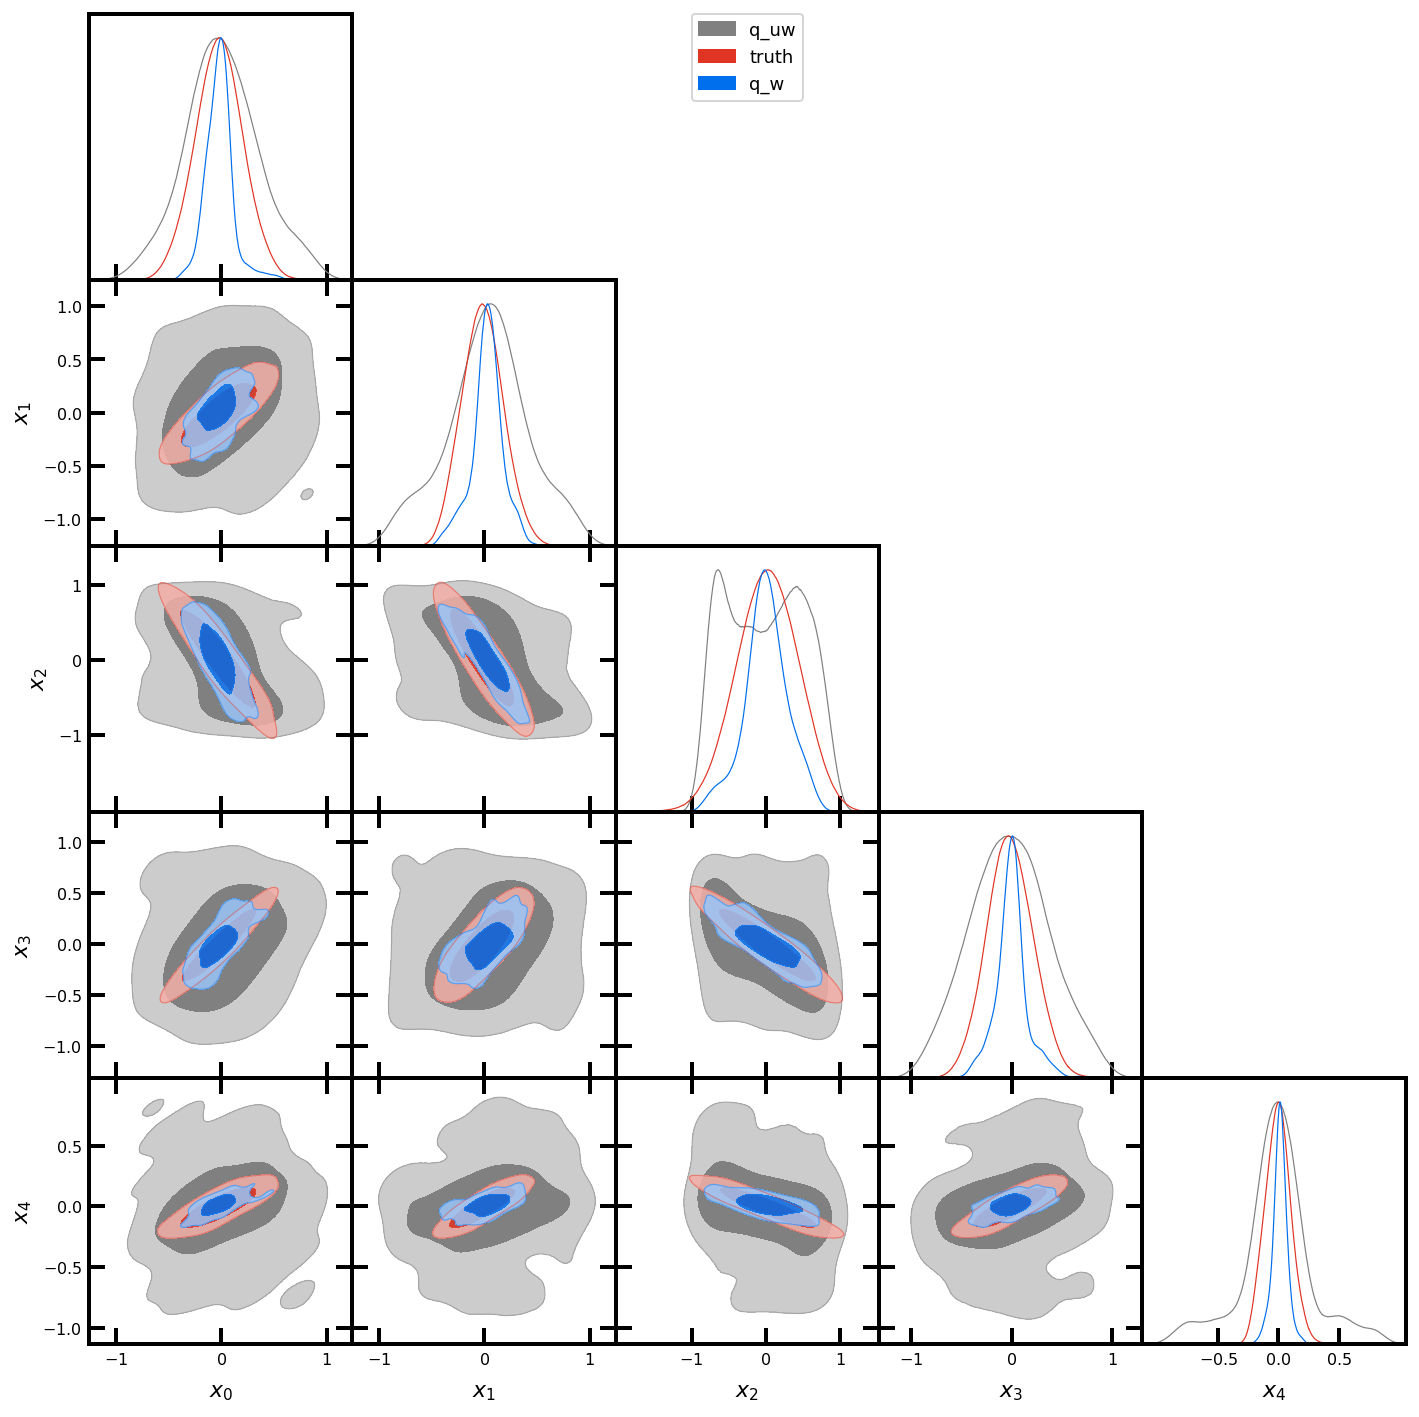

In [52]:
plot_corr_gd(cg5,Cov) 

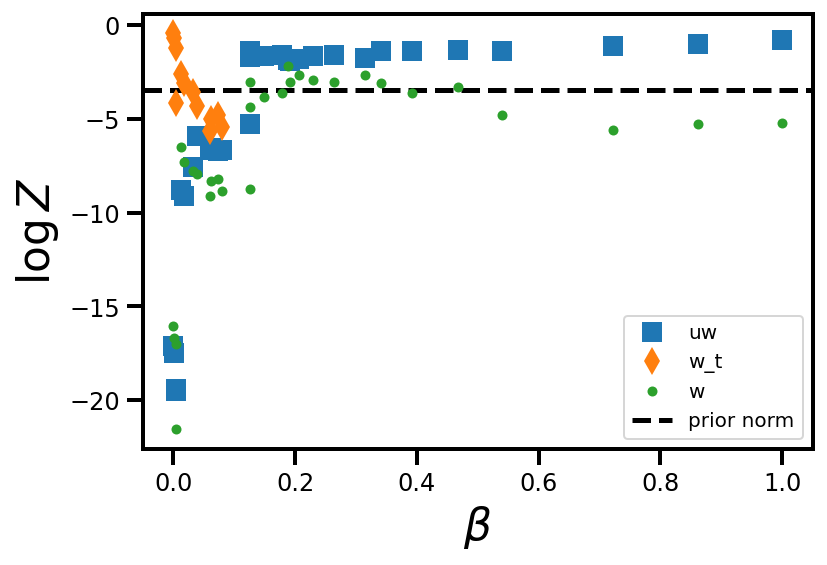

In [75]:
plot_Zs(cg5,-1,1,5,1)

## Quasi-double Gaussian (from recently-discussed paper)

In [61]:
warnings.filterwarnings('ignore')
n=10
mu1_grv,mu2_grv = jnp.concatenate([jnp.array([8,3]),jnp.zeros(8)]),jnp.concatenate([jnp.array([-2,3]),jnp.zeros(8)])
def log_like_ducg_grv(x): return log_like_ducg(x,w1=2/3,mu1=mu1_grv,mu2=mu2_grv,sig_scale=1,sig_scale_12=1)
grv10 = run_nfo(n=n,log_like=log_like_ducg_grv,log_prior=log_flat_prior,top_verbose=False,
                  low=-5.,high=10.,
                  beta_max=1,c=0,t_ess=0.9,frac_rel_beta_AF=0.5,gamma=0,
                 )

Inference mode is optimization. Maximum beta is: 1


Removed no burn in
46
Removed no burn in
Removed no burn in


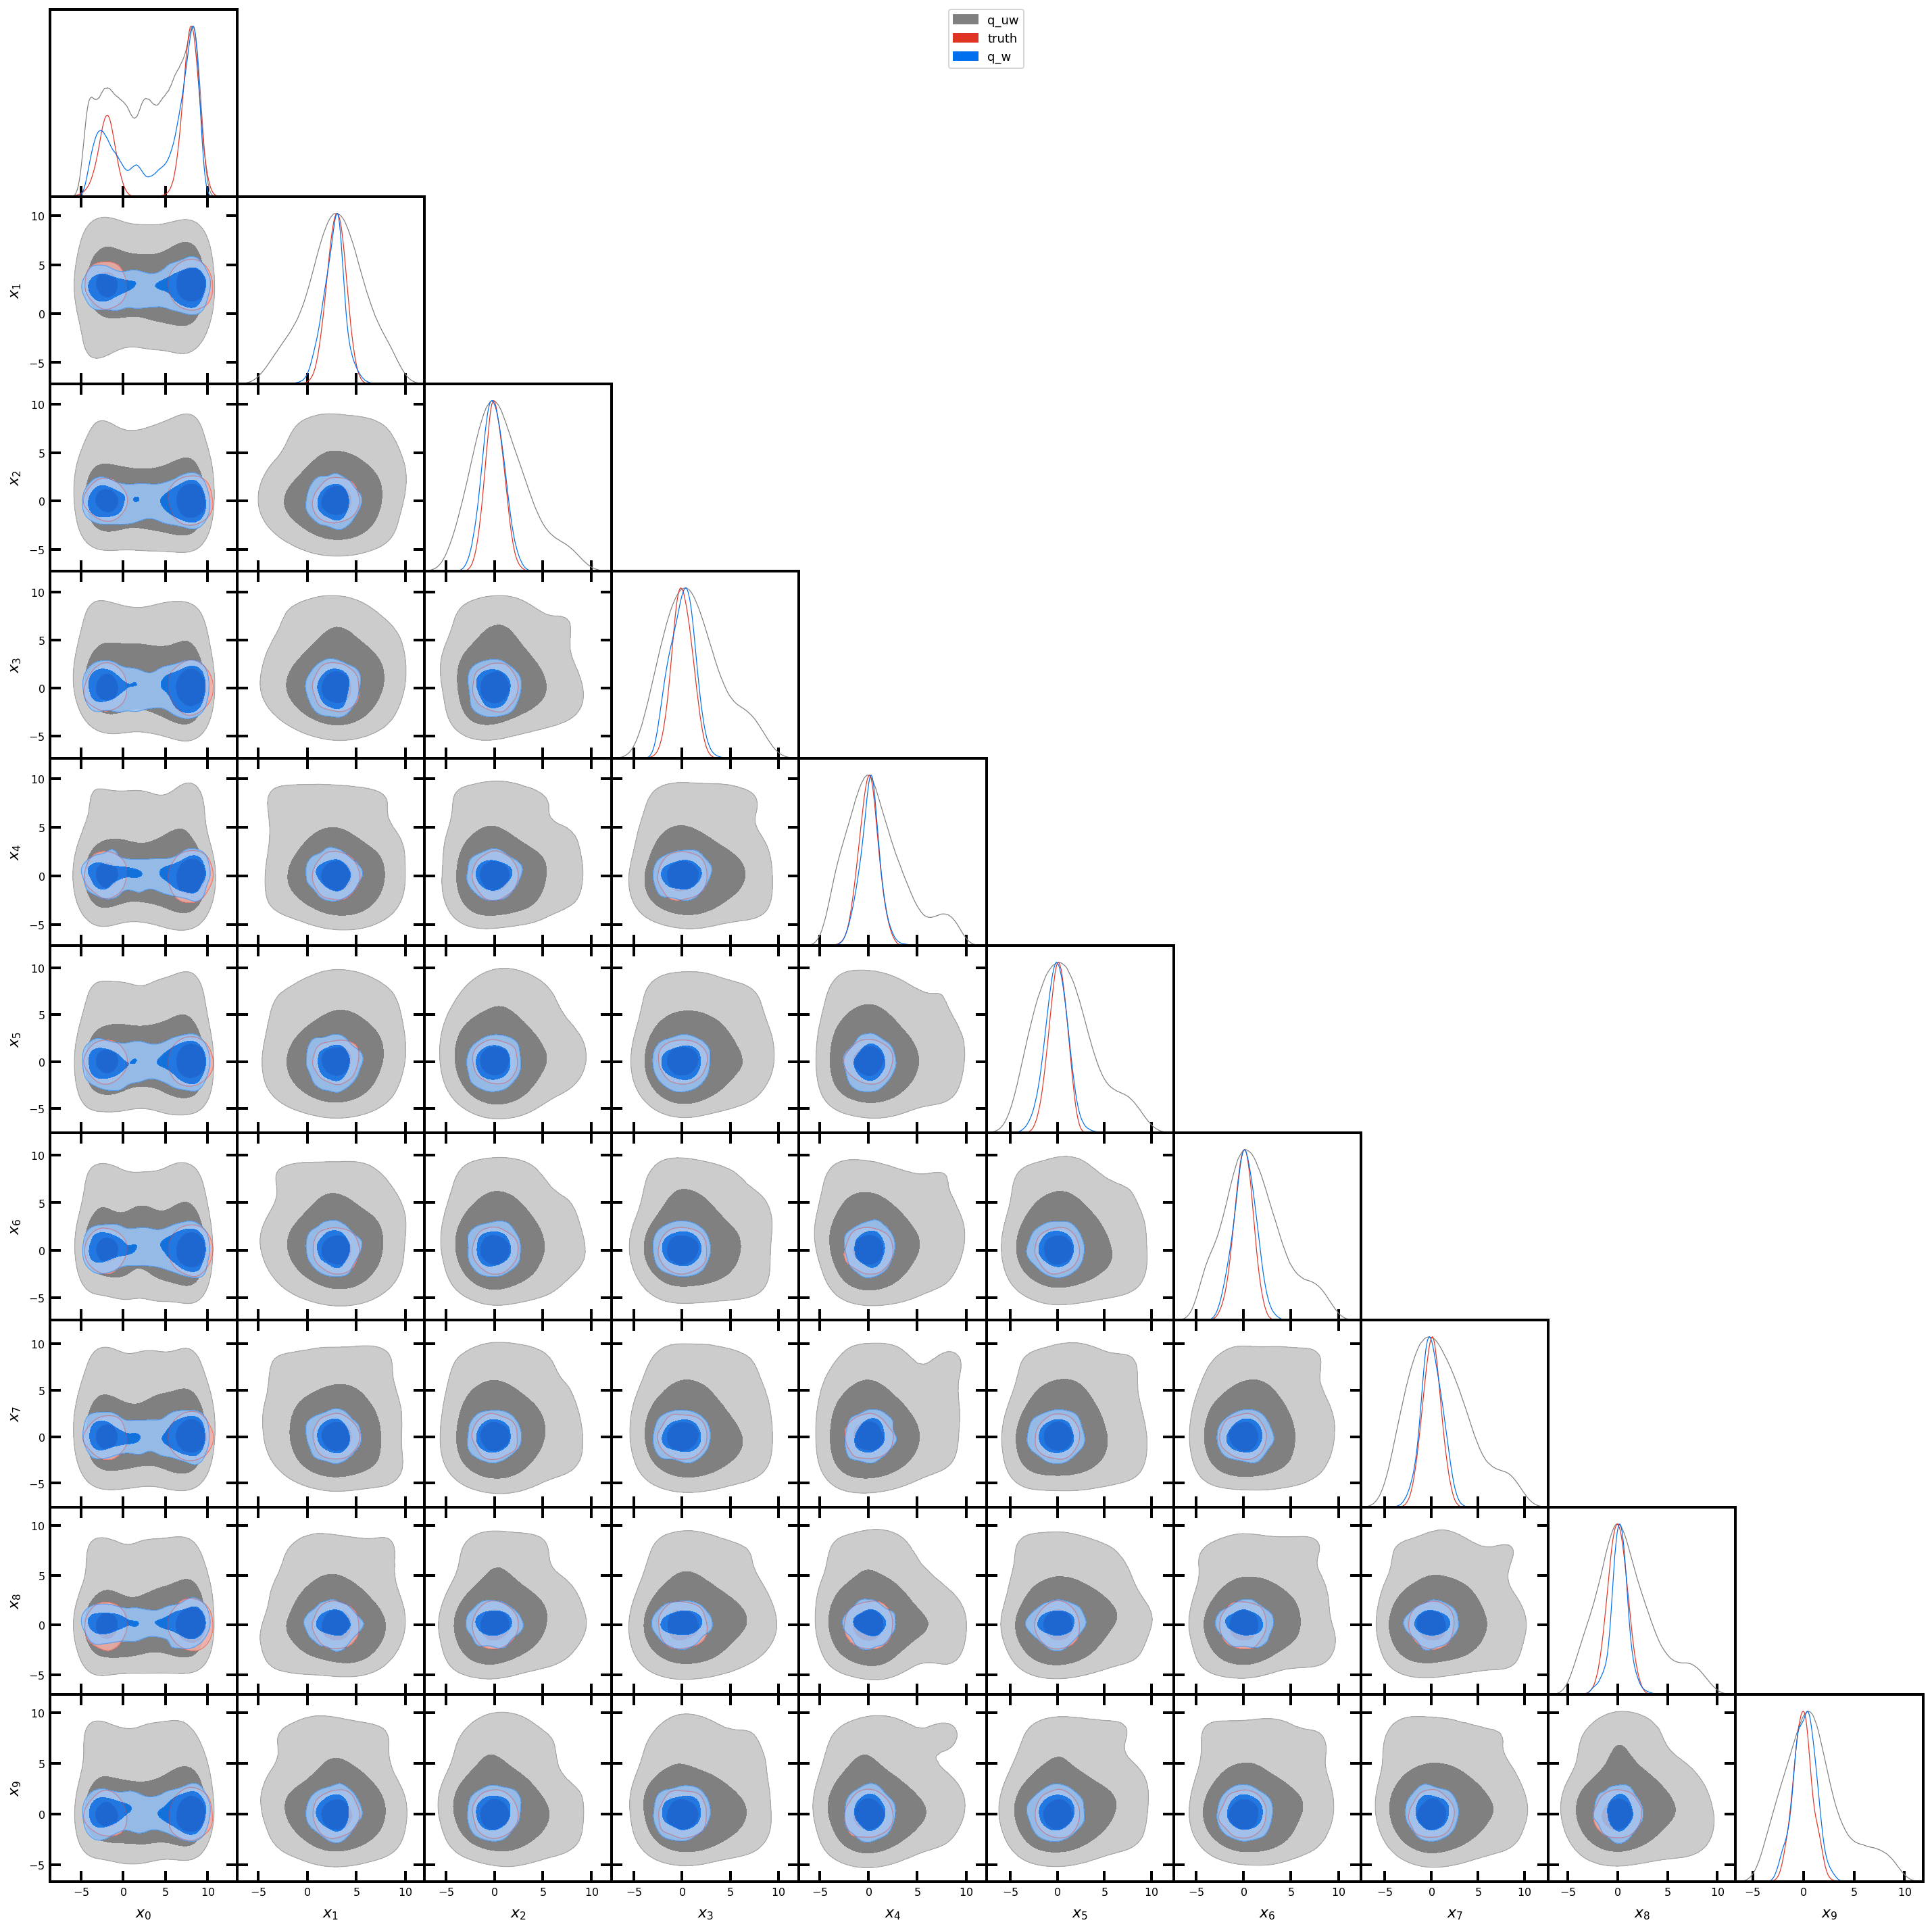

In [62]:
plot_corr_grv(grv10) 

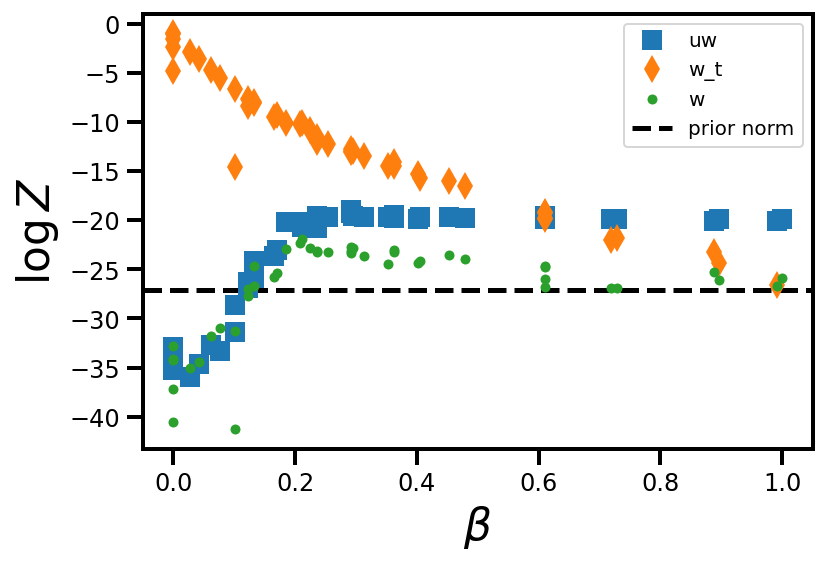

In [76]:
plot_Zs(grv10,-5,10,10,1)

# 2. Optimization
$\beta_{\rm{max}}=d$, $\gamma=0$, $Y=1$, $X=0.75 (1)$, $t_{ess}=0.7$

## Ackley function (d=10)
For some reason this takes much longer with new SINF updates - using exactly the same parameters before I only had 67 betas - here I am getting 100... Final result is similar though.

In [ ]:
def log_flat_one(x,low,high): return 0
def log_ack(n,x):
    #global min is at zero, which is one of the sobol points, so slightly shift
    a,b,c = 20,0.2,2*jnp.pi
    term1 = -a * jnp.exp(-b*jnp.sqrt(jnp.mean(x**2)))
    term2 = -jnp.exp(jnp.mean(jnp.cos(c*x)))

    f = term1 + term2 + a + jnp.exp(1)
    return jnp.log(a + jnp.exp(1)-f) #check to make sure always pos

def log_ack10(x): return log_ack(10,x)
n=10
ack10 = run_nfo(n=n,log_like=log_ack10,log_prior=log_flat_one,top_verbose=True,
                   low=-32.768,high=32.768,#this doesn't mean anything for prior, just for bounds
                   beta_max=10,t_ess=0.9
                 )

Removed no burn in
Removed no burn in
Removed no burn in


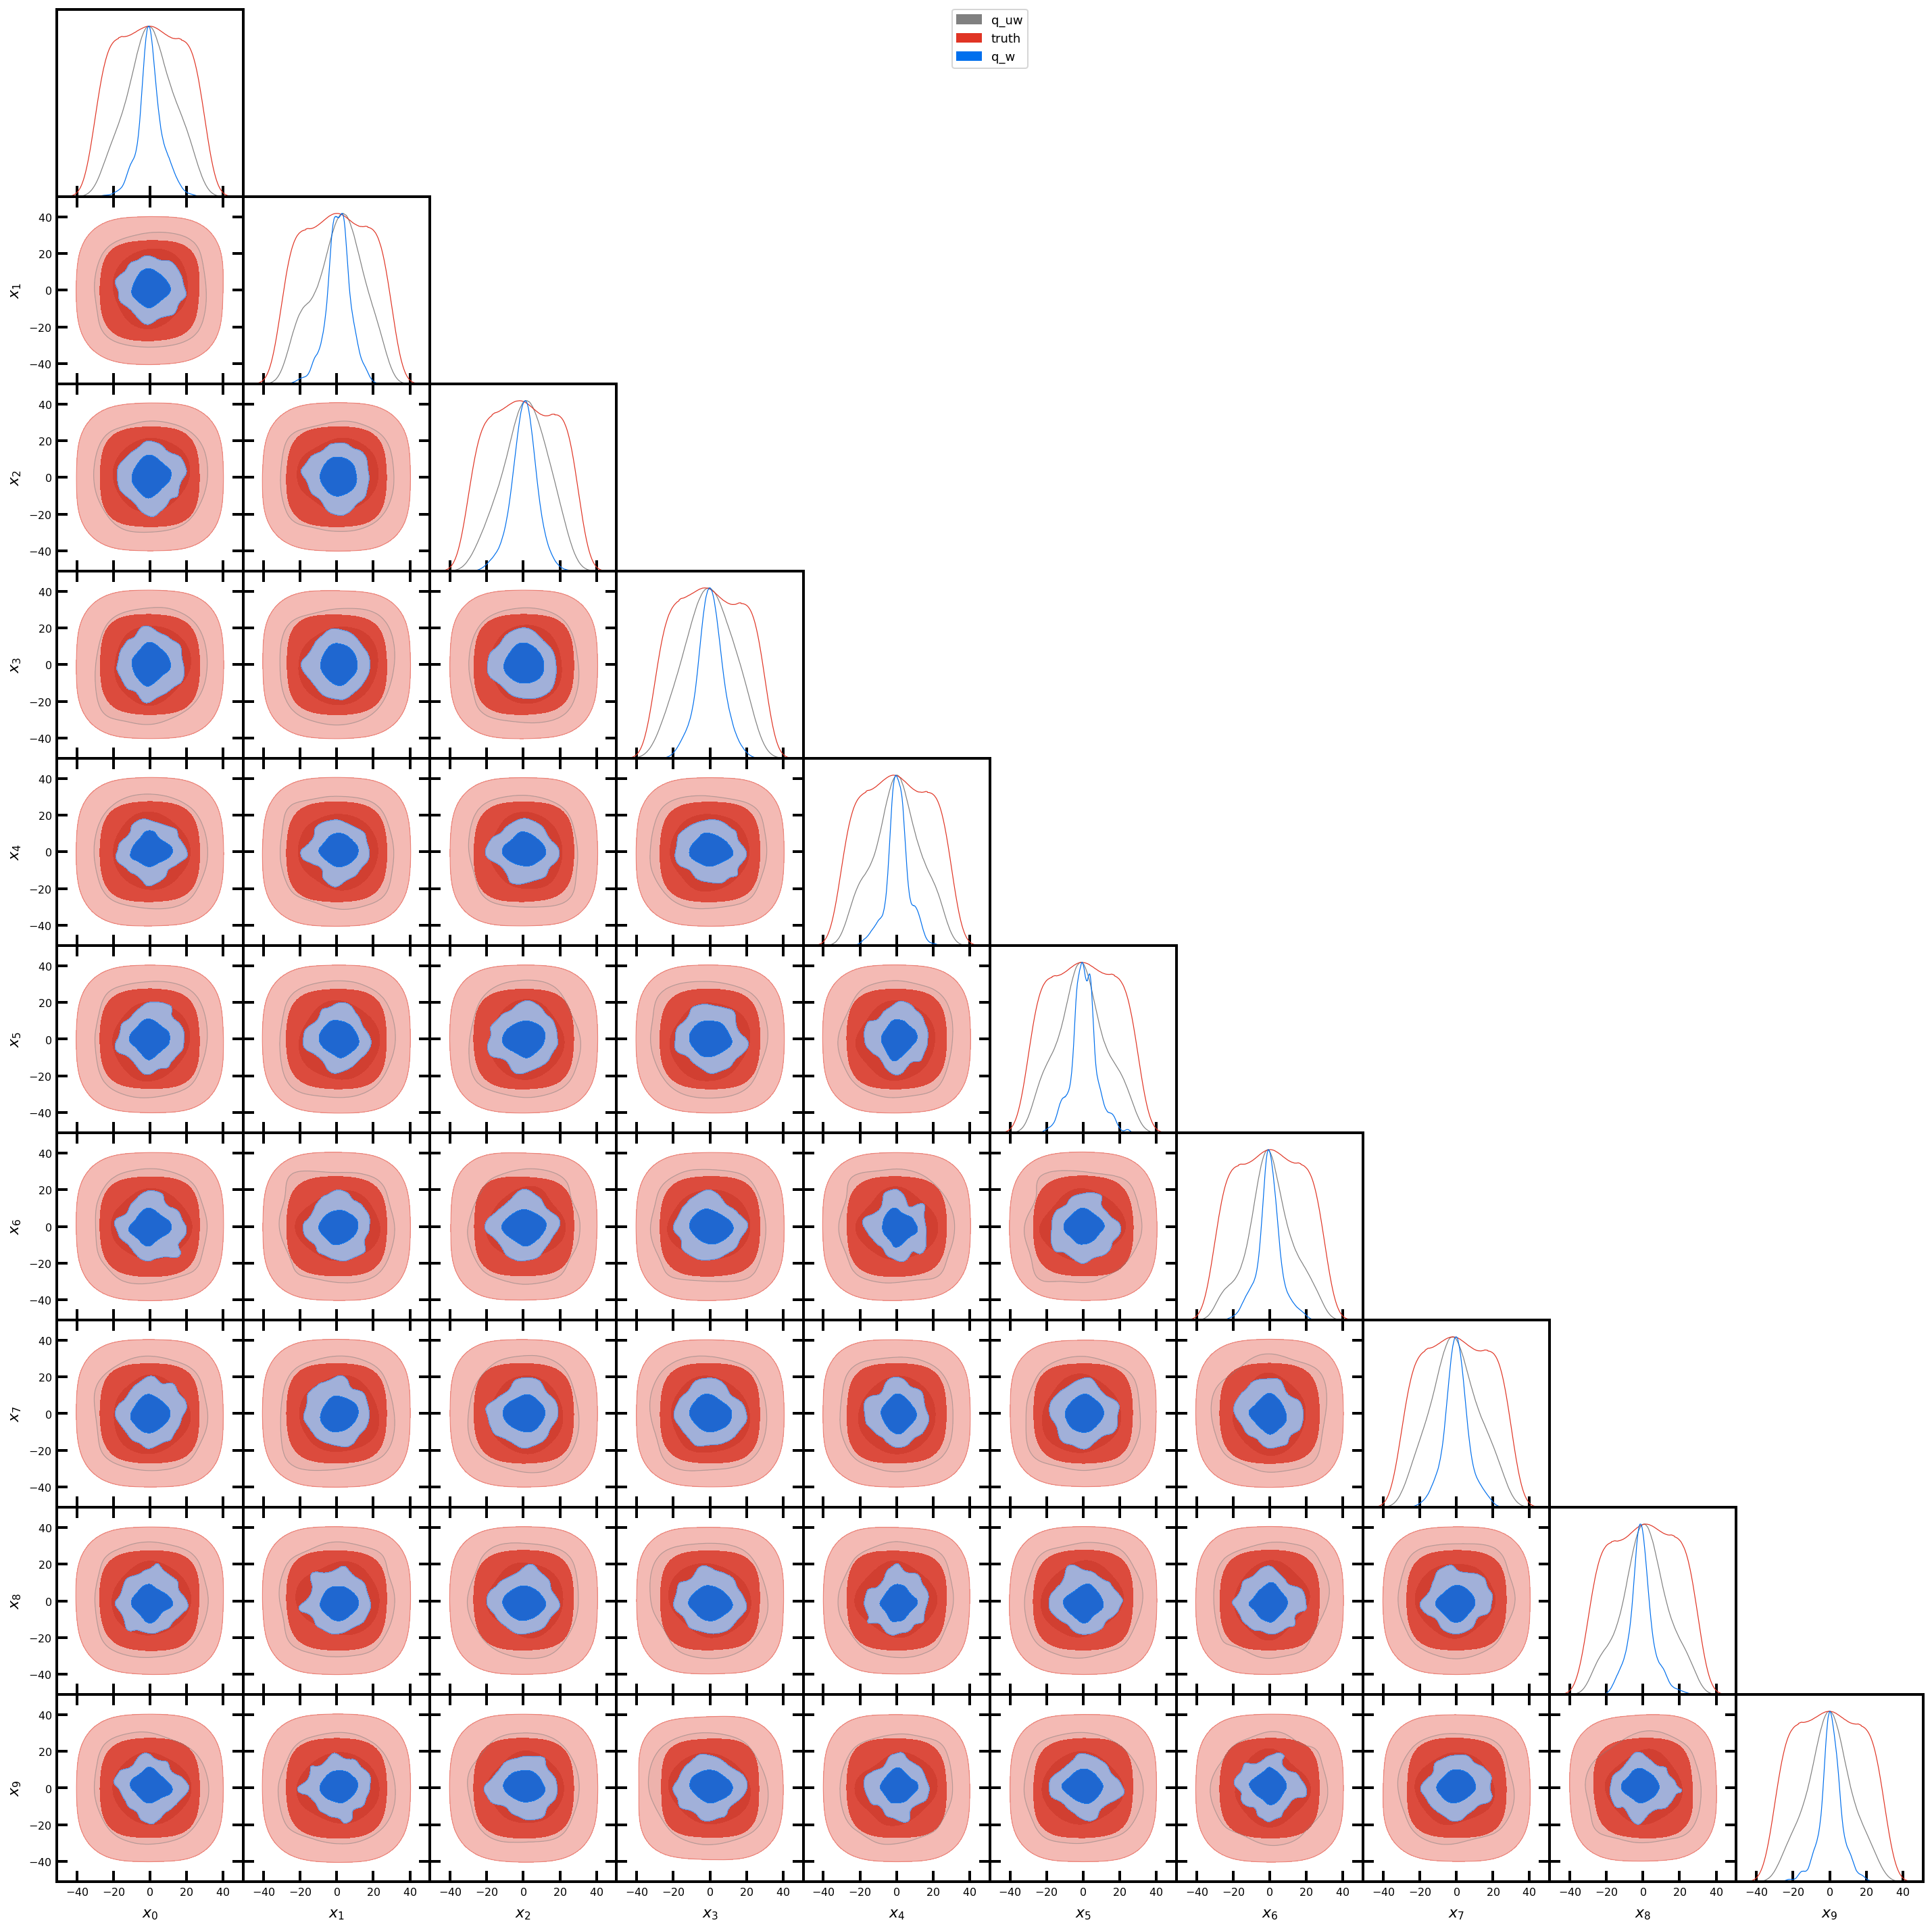

In [10]:
plot_opt_gd(ack10,log_ack,-32.768,32.768,beta_idx=None,Ngd=1000)

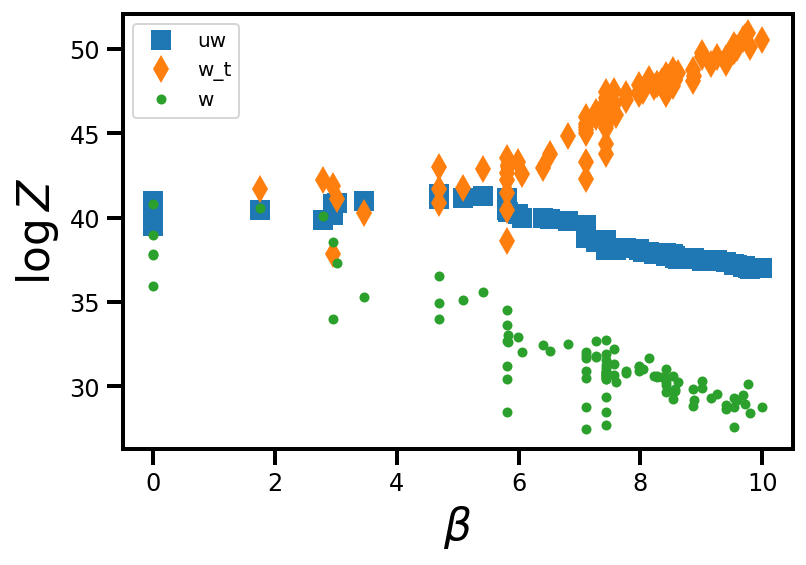

In [23]:
plot_Zs(ack10,None,None,10,10) #no normalization, ackley not normalized to 1
#why does this diverge?

Gap and best value (minimum is zero at zero)

In [15]:
def compute_gap(first,best,opt):
    return (first-best) / (first-opt)
ss,ws = ack10['q_models'][0]['q67_w'].sample(10000,device='cpu')
best = np.max(t2a(ws))
s_best = t2a(ss[np.argmax(t2a(ws))])
first = np.max(ack10['logp'][0]['q0'])
ss0,ws0 = ack10['q_models'][0]['q1_uw'].sample(10000,device='cpu')
first_uw = np.max(t2a(ws0)) #not sure this makes sense...idea is to find highest point as stand in for first...
sfirst = np.array(ack10['q_samples'][0]['q0'][np.argmax(ack10['logp'][0]['q0'])])
gap = compute_gap(first,best,0.)
print(gap,compute_gap(first_uw,best,0.)) #don't know how to interpret this gap...
print('val= ',best) #seems good

32.34582 0.31942824804329967
val=  -26.194602966308594


# Compare SINF to SNF

## QDG

In [10]:
grv10snf = run_nfo(n=n,log_like=log_like_ducg_grv,log_prior=log_flat_prior,top_verbose=True,
                  low=-5.,high=10.,
                  beta_max=1,d=2,b=2,t_ess=0.9,frac_rel_beta_AF=0.5,
                  c=0,
                  train_updates=True,
                   sgd_steps=100
                 )

Inference mode is optimization. Maximum beta is: 1
After first quw fit, beta=0.00
ESS3 = 73
beta_prod = 9.5367431640625e-07
beta_intern=0.0000
norm-logZ_w_pq = 2.5148
norm-logZ_t = 26.8112
After first quw fit, beta=0.00
ESS3 = 19
beta_prod = 1.9073481780651491e-06
beta_intern=0.0000
norm-logZ_w_pq = 0.1804
norm-logZ_t = 26.7949
After first quw fit, beta=0.00
using beta2=0.00 at idx 1, at stage-1 = 2
ESS3 = 37
beta_prod = 2.861021584976914e-06
beta_intern=0.0000
norm-logZ_w_pq = 0.0464
norm-logZ_t = 26.7843
After first quw fit, beta=0.00
using beta2=0.00 at idx 2, at stage-1 = 3
ESS3 = 47
beta_prod = 3.814694537141762e-06
beta_intern=0.0000
norm-logZ_w_pq = 0.4705
norm-logZ_t = 26.7964
After first quw fit, beta=0.00
using beta2=0.00 at idx 2, at stage-1 = 4
ESS3 = 38
beta_prod = 4.7683670345599095e-06
beta_intern=0.0000
norm-logZ_w_pq = 3.3645
norm-logZ_t = 26.9405
After first quw fit, beta=0.00
using beta2=0.00 at idx 3, at stage-1 = 5
ESS3 = 62
beta_prod = 5.7220390772315735e-06
beta_

using beta2=0.41 at idx 24, at stage-1 = 45
ESS3 = 89
beta_prod = 0.7221050977342591
beta_intern=0.7221
norm-logZ_w_pq = 14.9278
norm-logZ_t = 17.8183
After first quw fit, beta=0.72
using beta2=0.41 at idx 24, at stage-1 = 46
ESS3 = 90
beta_prod = 0.7595434249490758
beta_intern=0.7595
norm-logZ_w_pq = 14.5916
norm-logZ_t = 17.6366
After first quw fit, beta=0.76
using beta2=0.41 at idx 24, at stage-1 = 47
ESS3 = 90
beta_prod = 0.7740800254379538
beta_intern=0.7741
norm-logZ_w_pq = 14.4852
norm-logZ_t = 17.5708
After first quw fit, beta=0.77
using beta2=0.41 at idx 24, at stage-1 = 48
ESS3 = 90
beta_prod = 0.7812631502889034
beta_intern=0.7813
norm-logZ_w_pq = 14.5116
norm-logZ_t = 17.5389
After first quw fit, beta=0.78
using beta2=0.41 at idx 24, at stage-1 = 49
ESS3 = 88
beta_prod = 0.7812637314279194
beta_intern=0.7813
norm-logZ_w_pq = 14.5245
norm-logZ_t = 17.5419
After first quw fit, beta=0.78
using beta2=0.41 at idx 24, at stage-1 = 50
ESS3 = 84
beta_prod = 0.7812643125666583
beta_

ESS3 = 90
beta_prod = 0.971398446074873
beta_intern=0.9714
norm-logZ_w_pq = 14.7112
norm-logZ_t = 18.2883
After first quw fit, beta=0.97
using beta2=0.49 at idx 26, at stage-1 = 91
ESS3 = 90
beta_prod = 0.975416420894893
beta_intern=0.9754
norm-logZ_w_pq = 14.7098
norm-logZ_t = 18.2736
After first quw fit, beta=0.98
using beta2=0.49 at idx 26, at stage-1 = 92
ESS3 = 88
beta_prod = 0.9754173980139373
beta_intern=0.9754
norm-logZ_w_pq = 14.6409
norm-logZ_t = 18.2736
After first quw fit, beta=0.98
using beta2=0.49 at idx 26, at stage-1 = 93
ESS3 = 89
beta_prod = 0.9754183751320499
beta_intern=0.9754
norm-logZ_w_pq = 14.6845
norm-logZ_t = 18.2736
After first quw fit, beta=0.98
using beta2=0.49 at idx 26, at stage-1 = 94
ESS3 = 89
beta_prod = 0.9754193522492305
beta_intern=0.9754
norm-logZ_w_pq = 14.6745
norm-logZ_t = 18.2736
After first quw fit, beta=0.98
using beta2=0.49 at idx 26, at stage-1 = 95
ESS3 = 90
beta_prod = 0.9774204863268687
beta_intern=0.9774
norm-logZ_w_pq = 14.6704
norm-lo

Removed no burn in
118
Removed no burn in
Removed no burn in


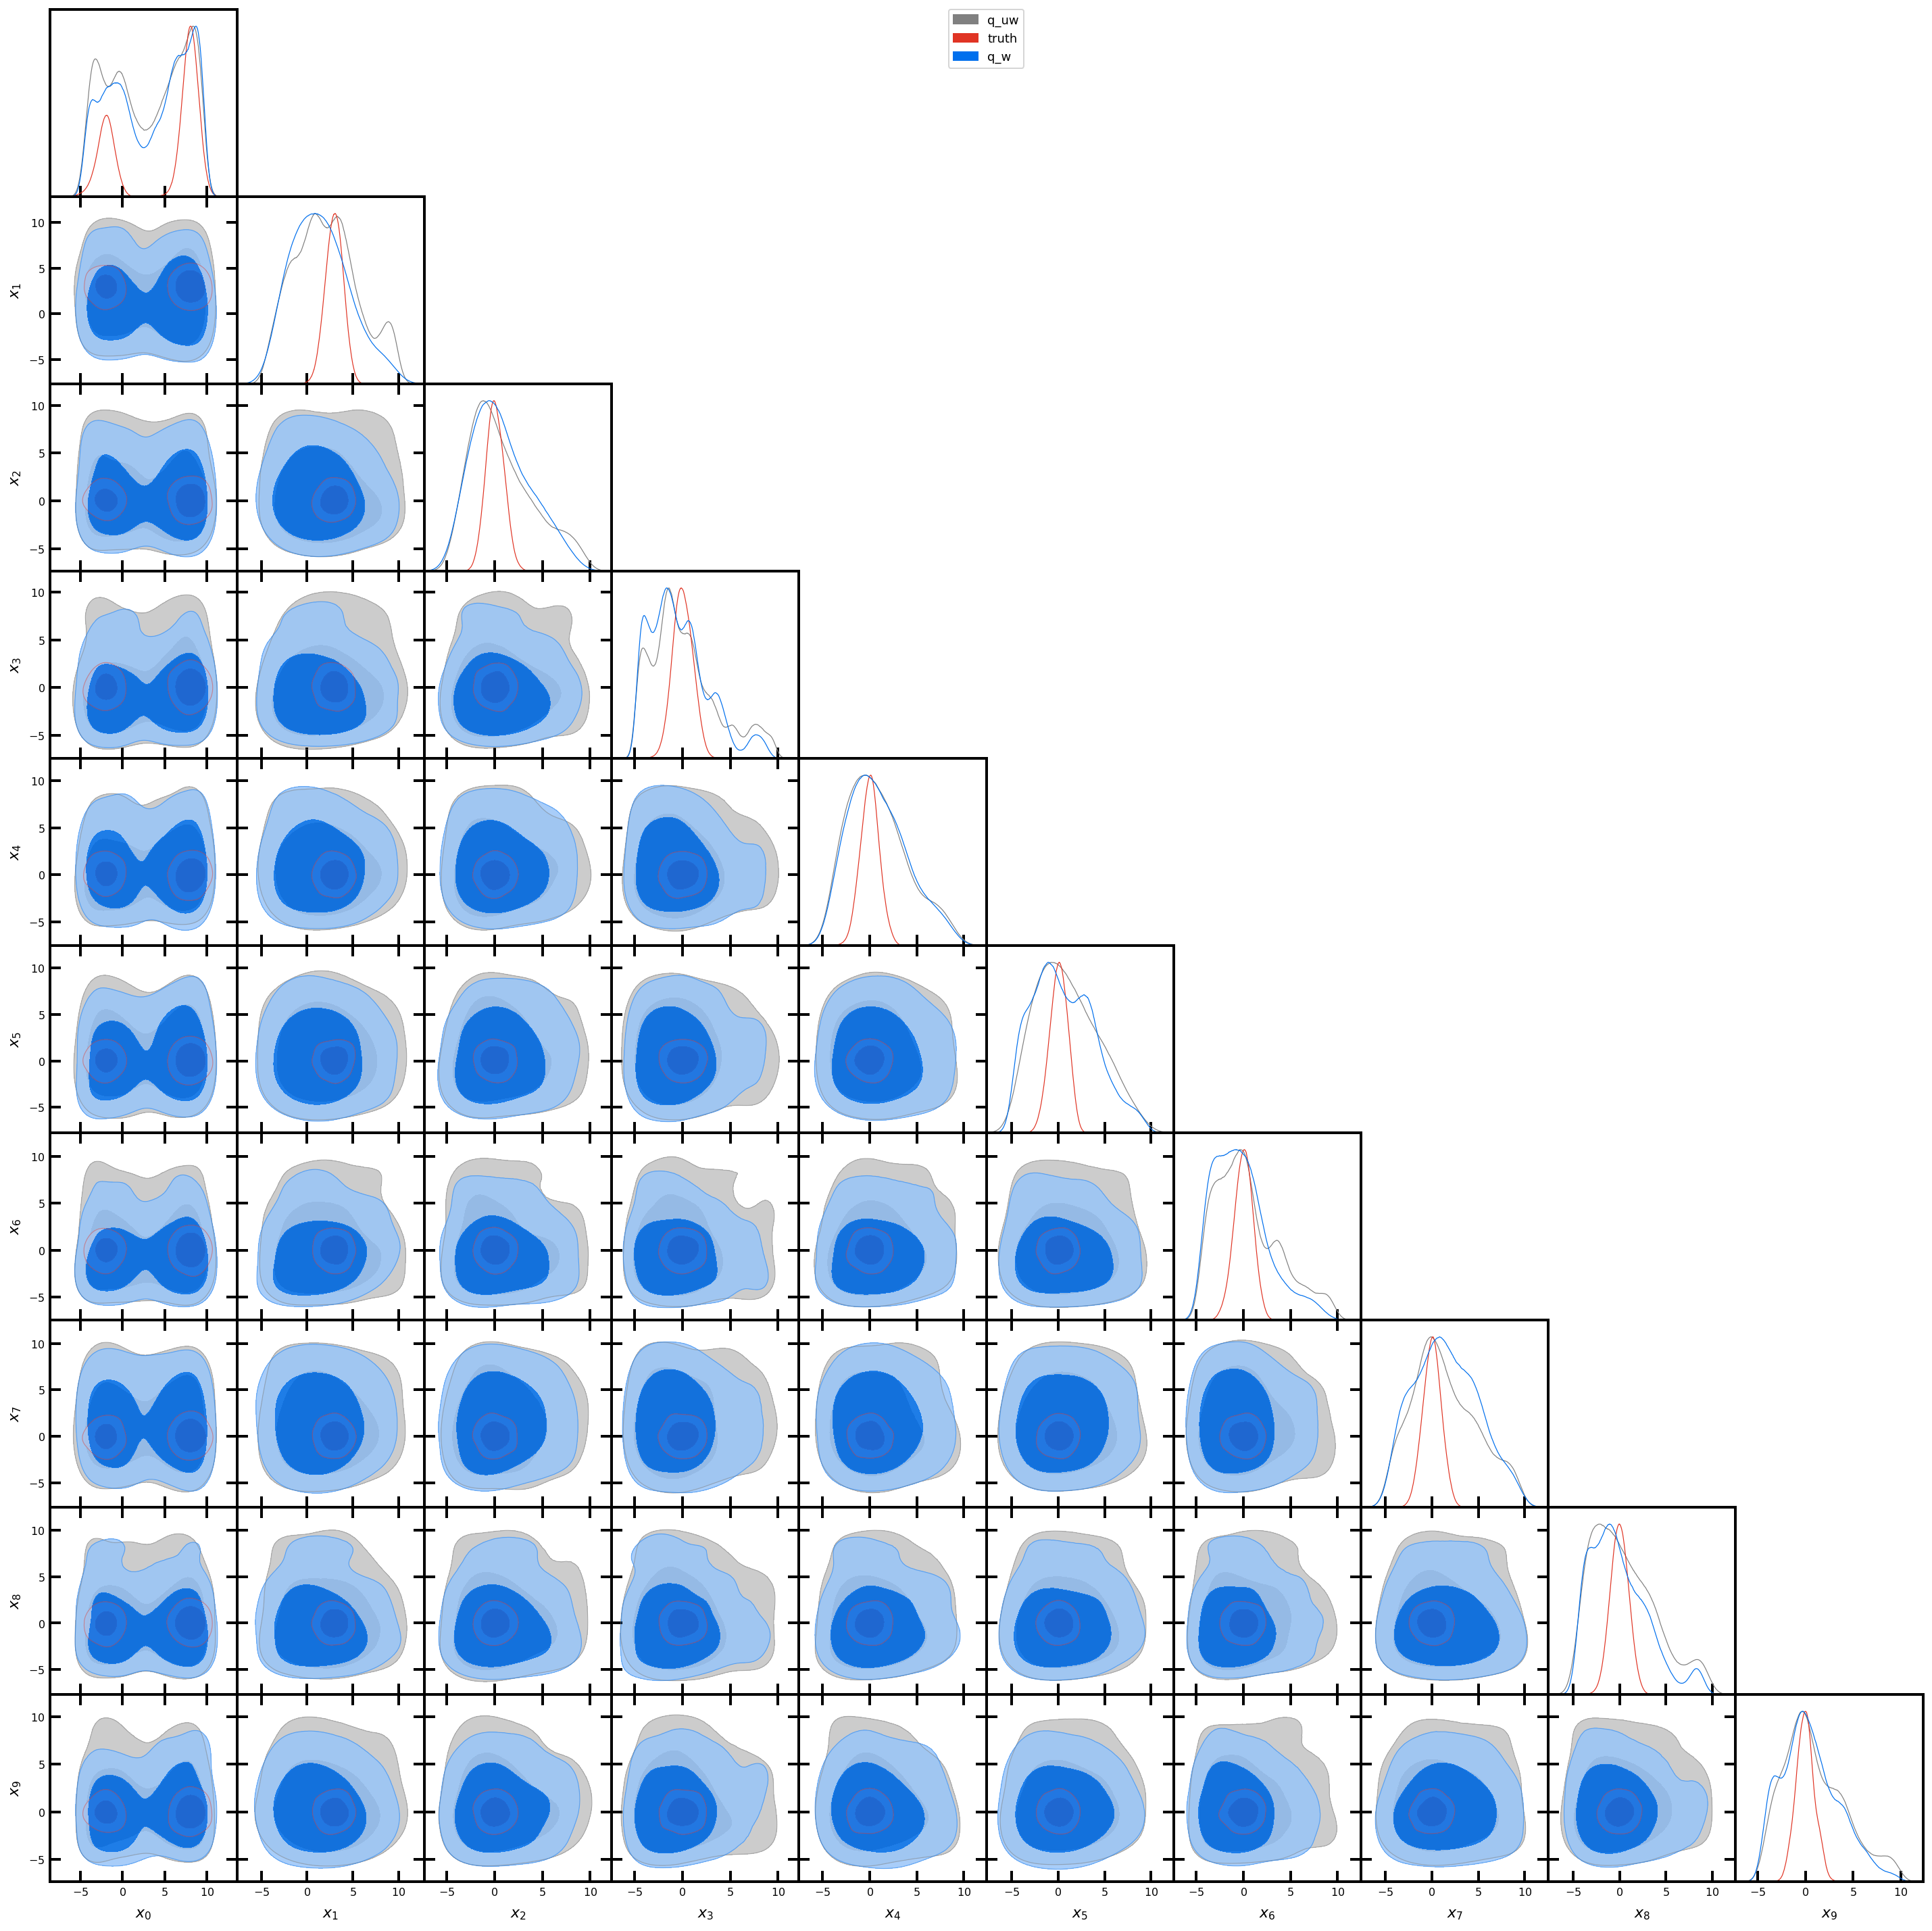

In [11]:
plot_corr_grv(grv10snf) 

<hr style="border:2px solid gray"> </hr>


# Extra

### CG at the same settings as sampling but with no latent sampling

Removed no burn in
Removed no burn in
Removed no burn in


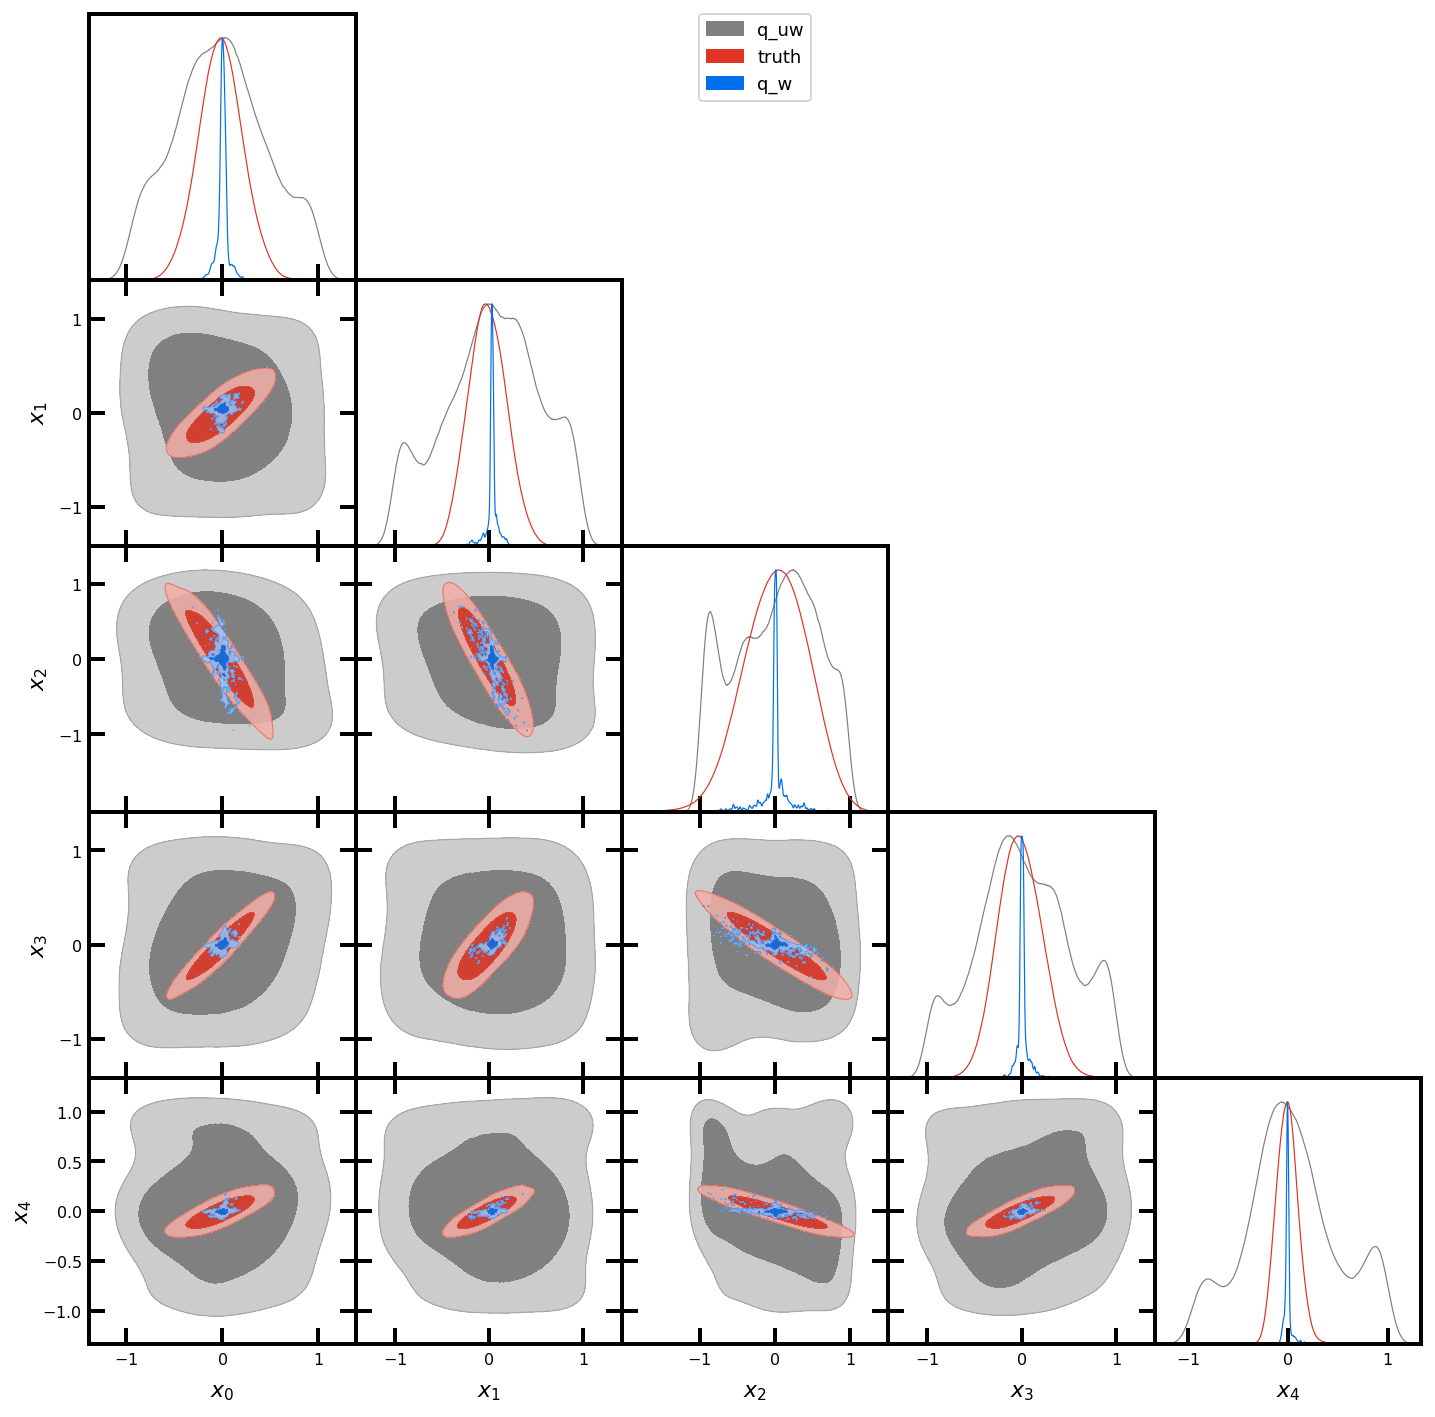

In [7]:
plot_corr_gd(cg5,Cov) #d=0 

## Varying a few new things

### $p \geq \{5\%,10\%,33\%\}p_{\rm{max}}$ 


In [22]:
n=5
ls,vl = np.log(np.array([0.05,0.1,.33])),[]
for l in ls: vl.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,
                               logp_cut=l))

Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


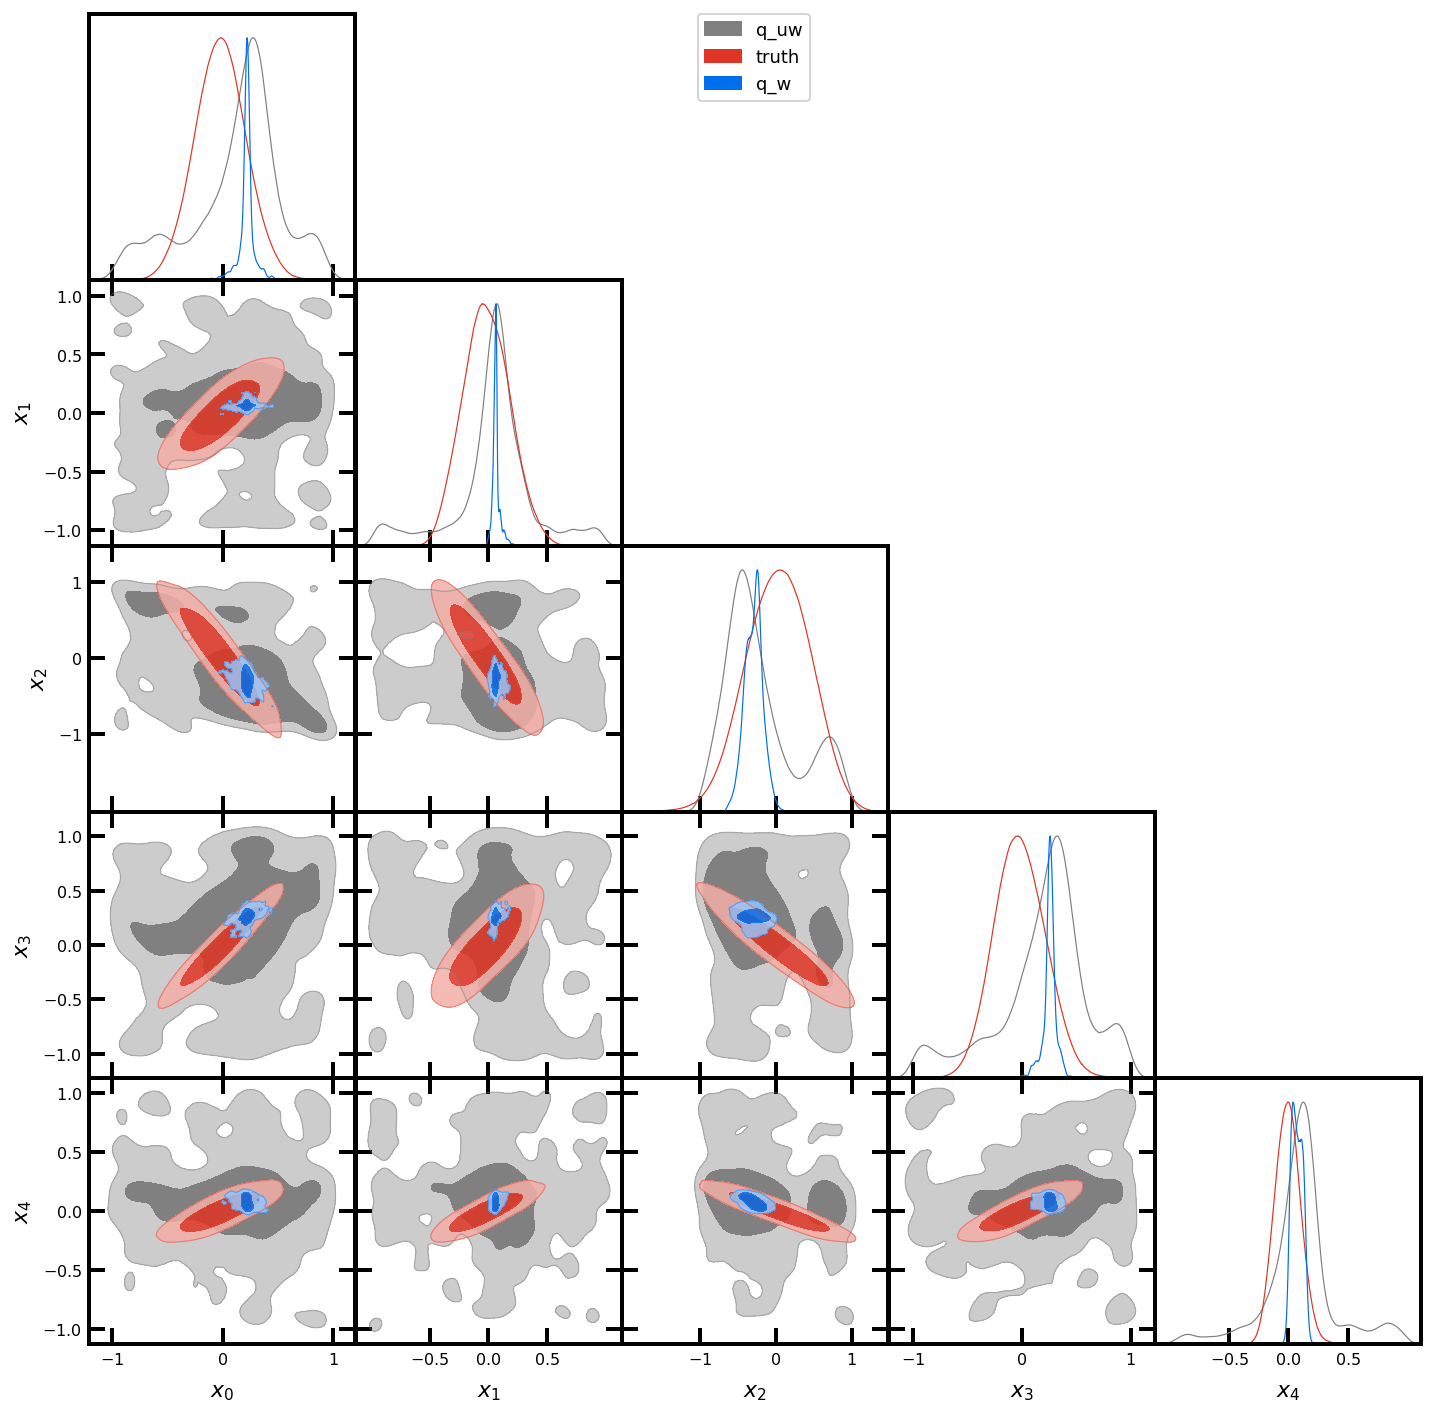

Removed no burn in
Removed no burn in
Removed no burn in


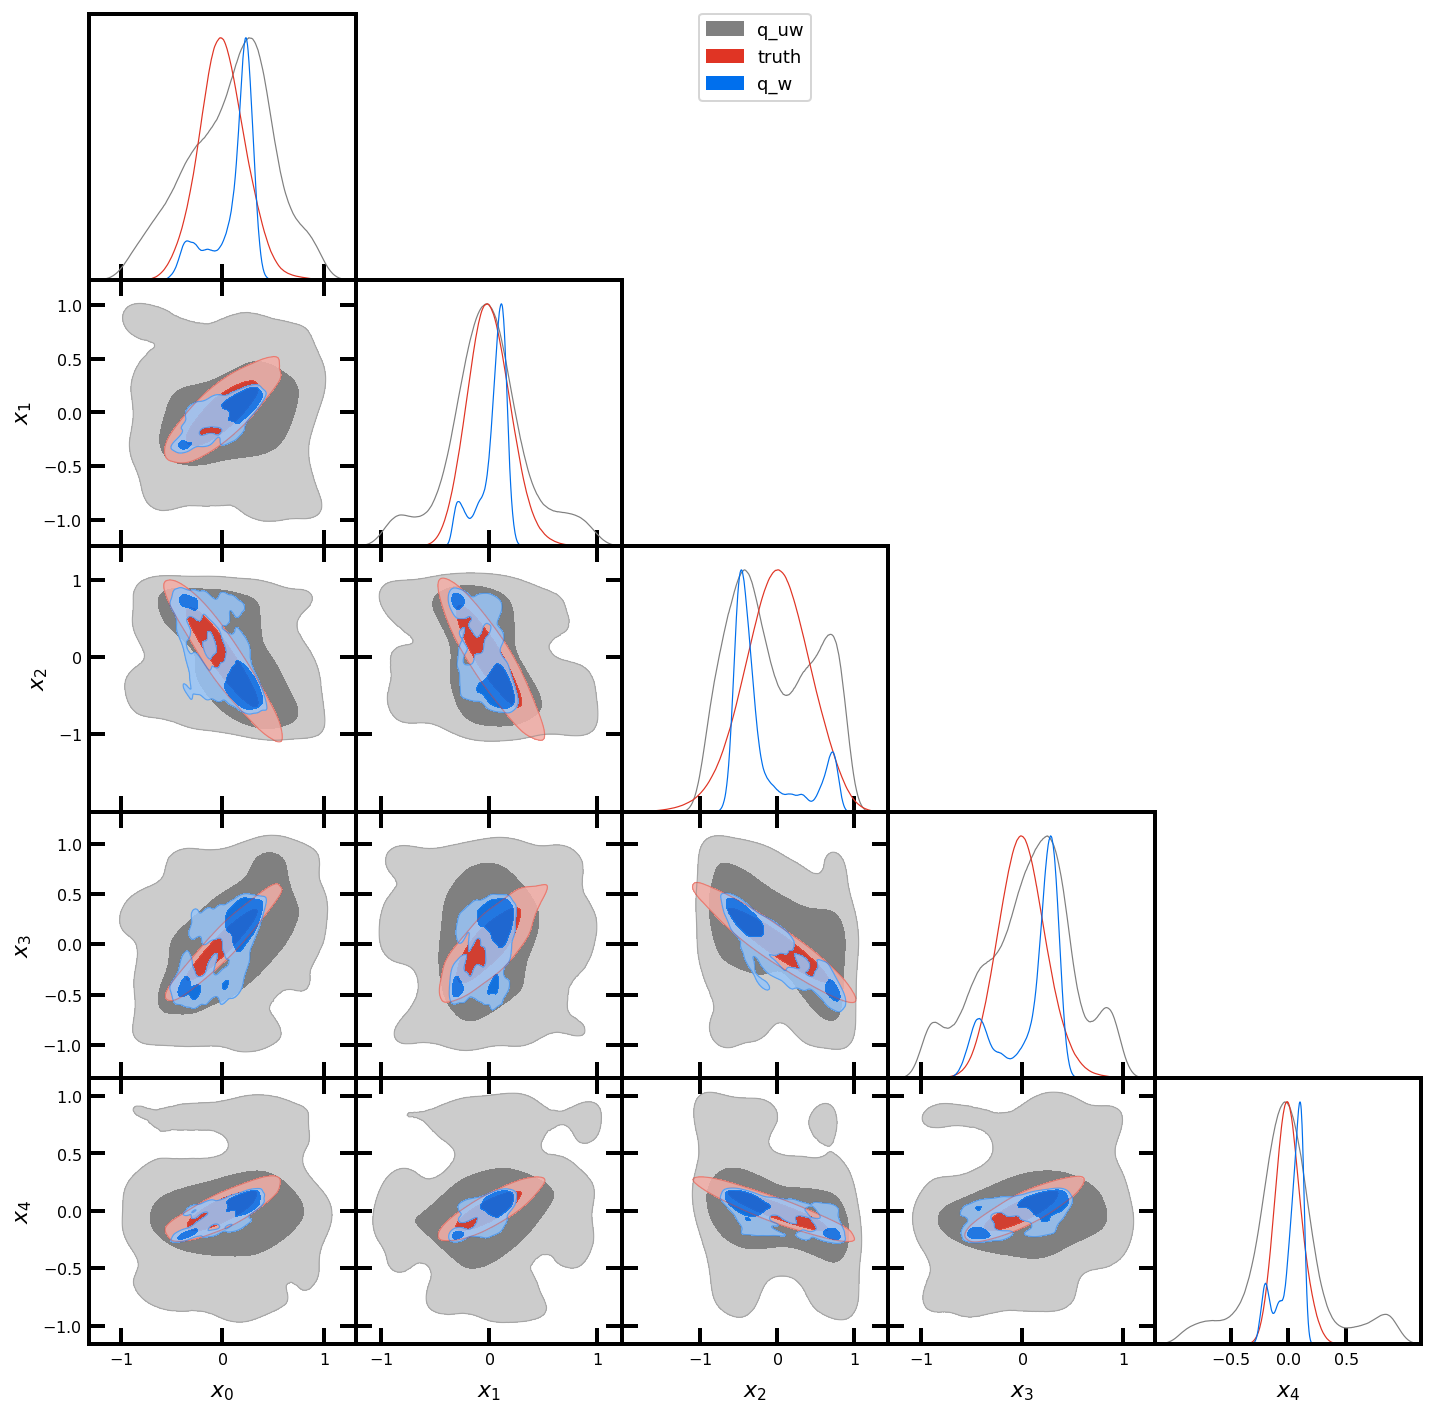

Removed no burn in
Removed no burn in
Removed no burn in


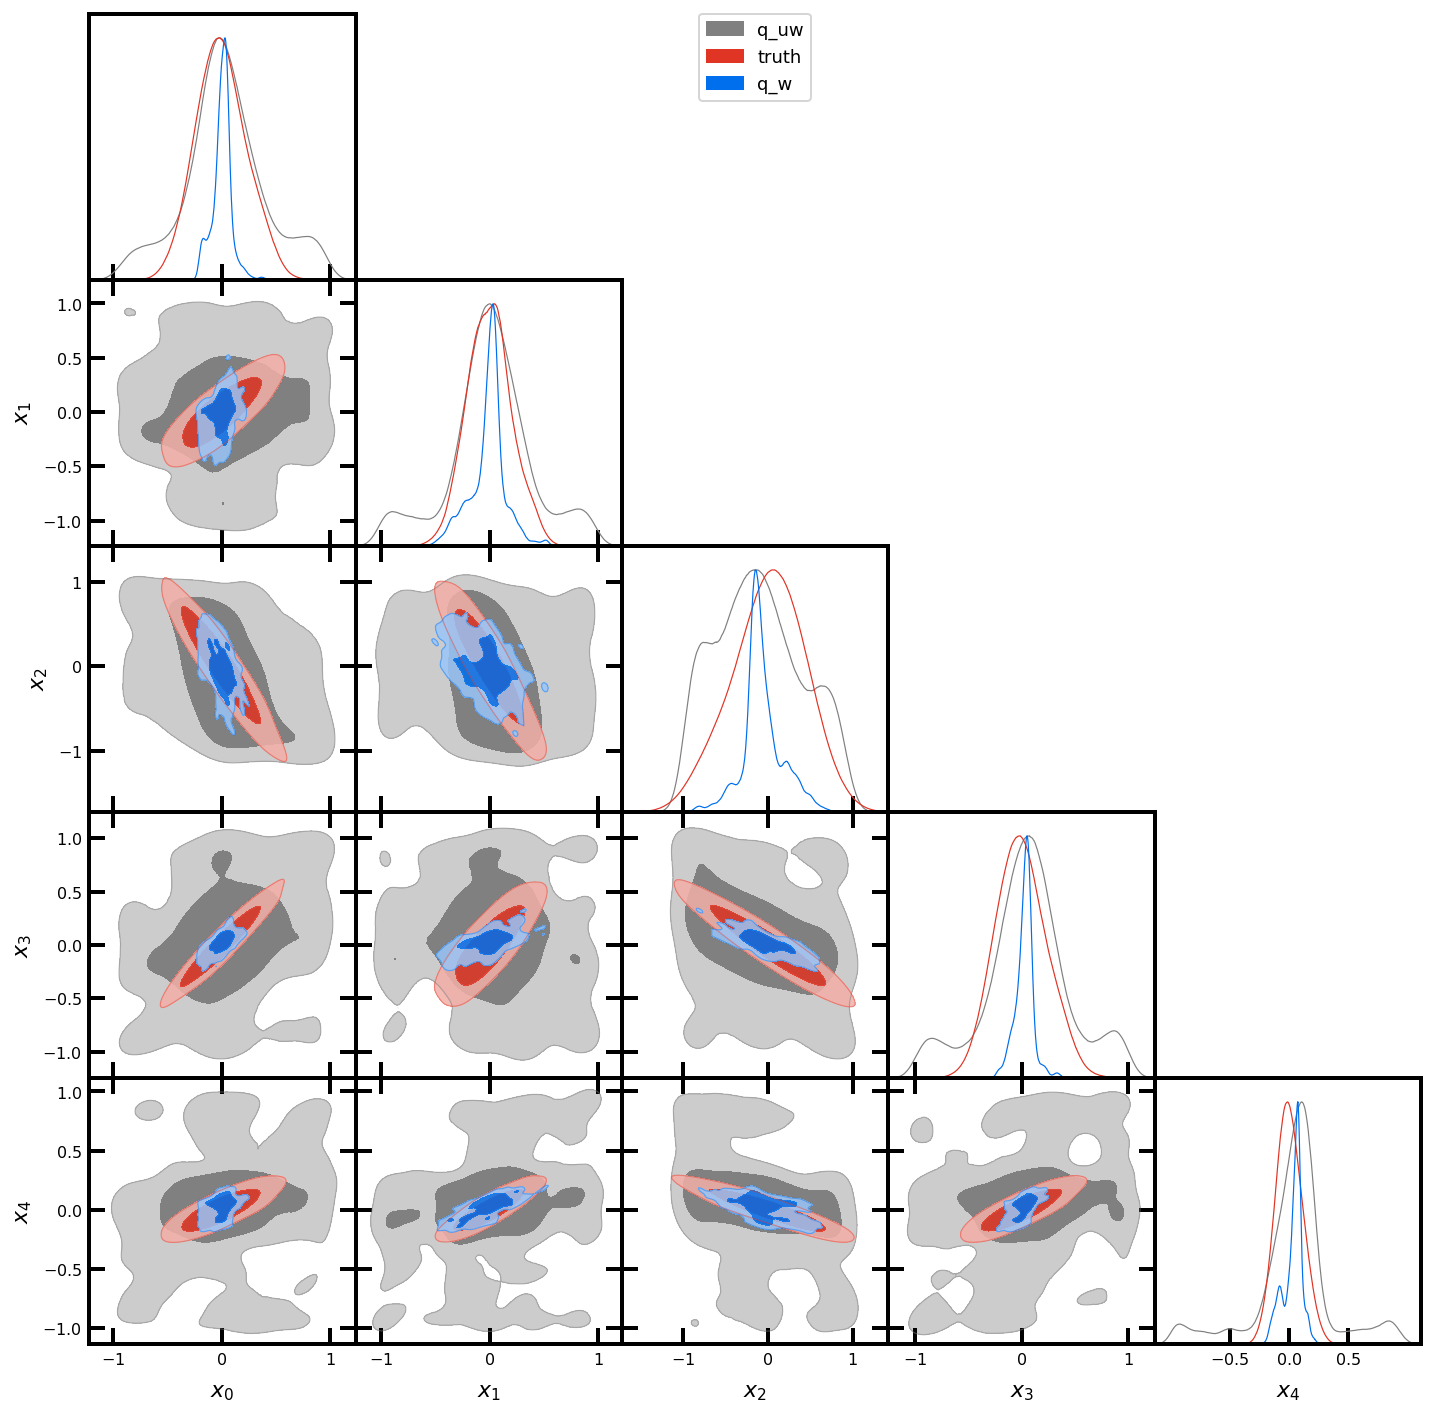

In [18]:
for t in vl: plot_corr_gd(t,Cov) #old default settings

### $\beta_{\rm{max}}=\{1,1.5,2,5\}$

In [81]:
bes,vbe = [1,1.5,2.,5.],[]
for be in bes: vbe.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,beta_max=be))

Inference mode is optimization. Maximum beta is: 1
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 2.0
Inference mode is optimization. Maximum beta is: 5.0


Removed no burn in
Removed no burn in
Removed no burn in


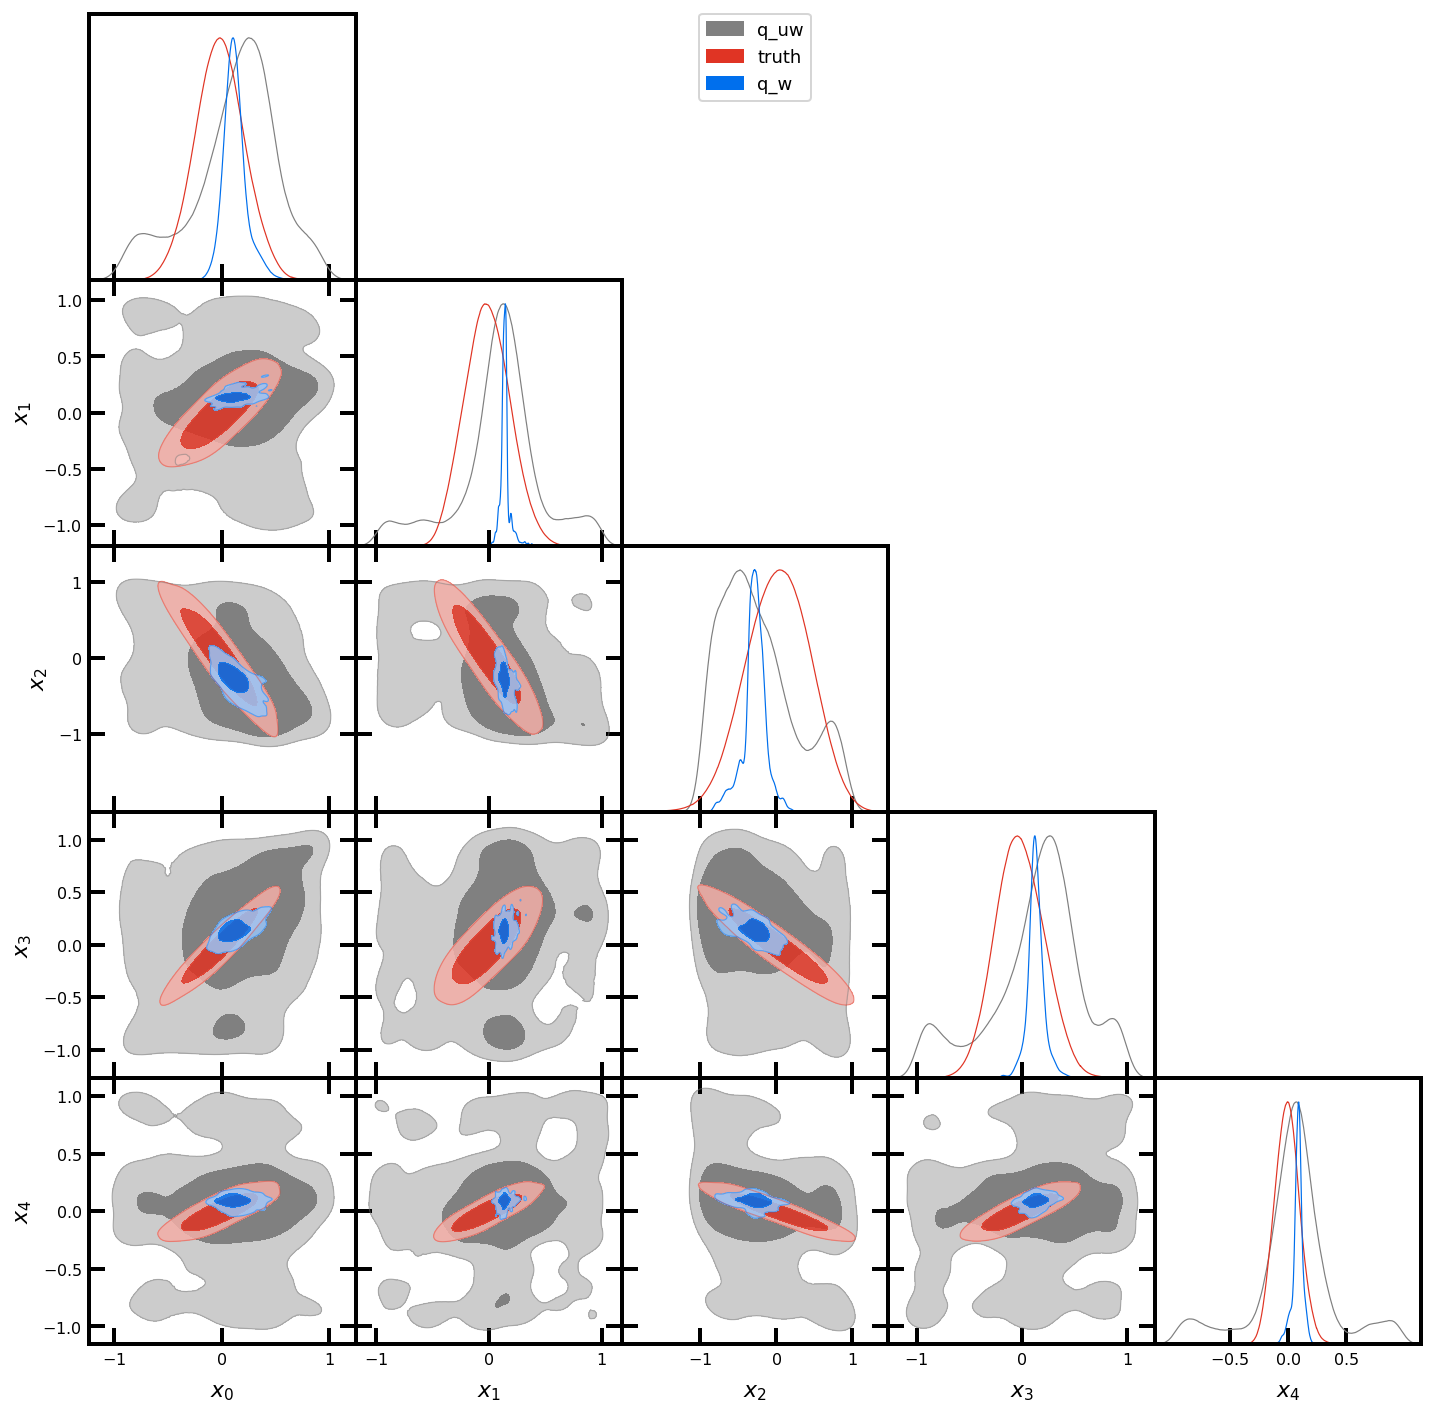

Removed no burn in
Removed no burn in
Removed no burn in


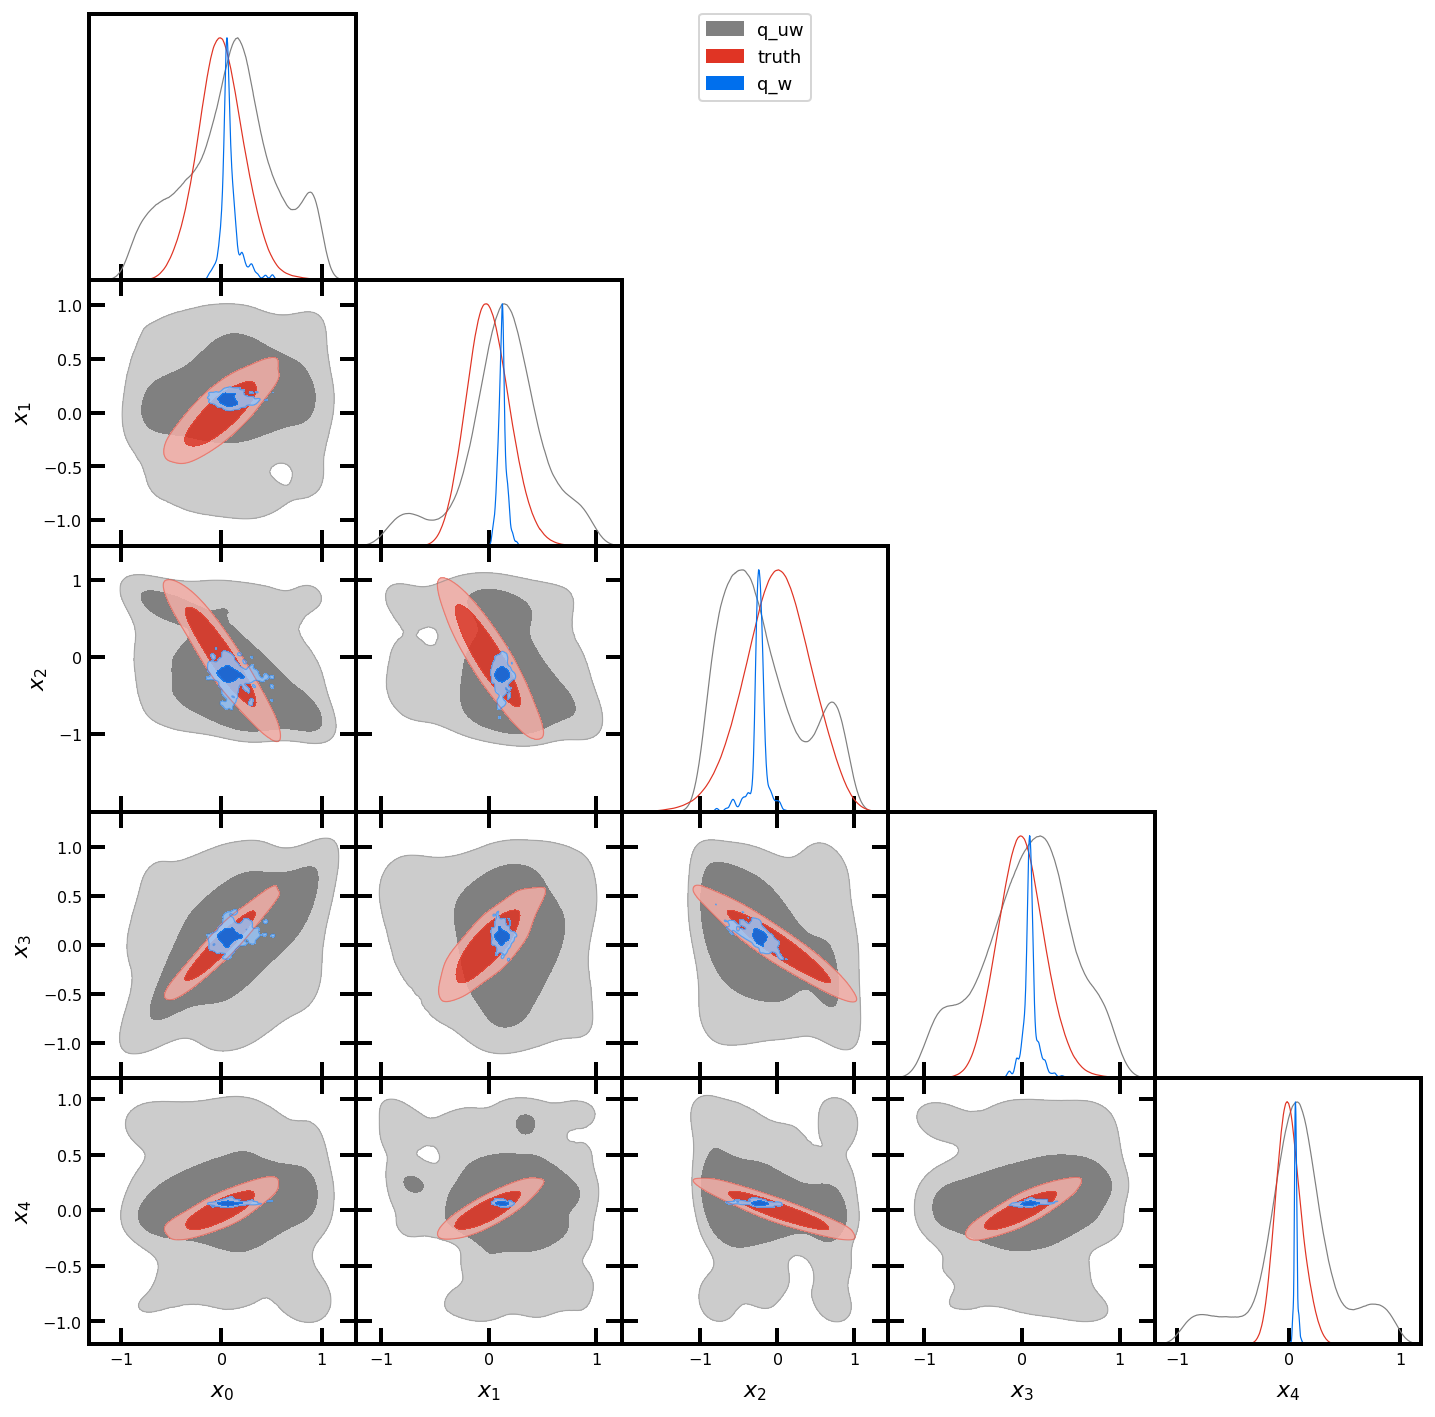

Removed no burn in
Removed no burn in
Removed no burn in


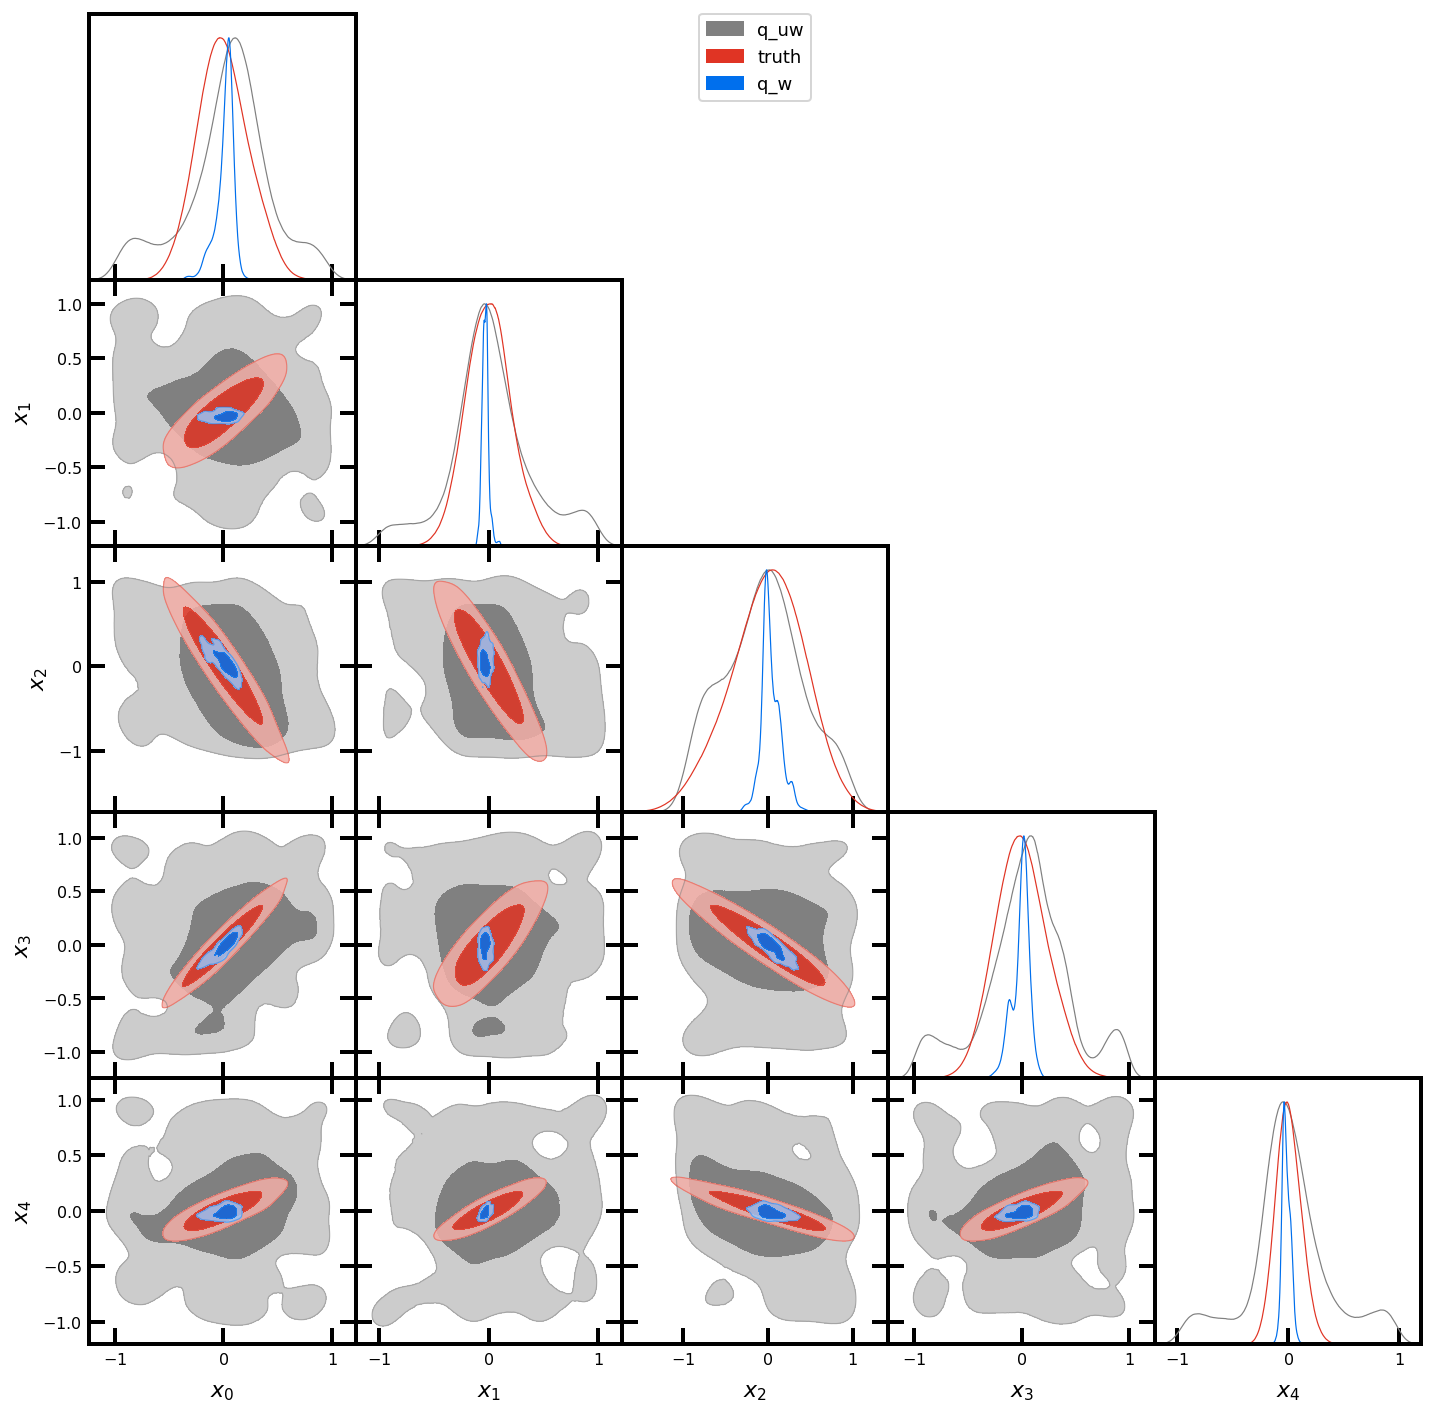

Removed no burn in
Removed no burn in
Removed no burn in


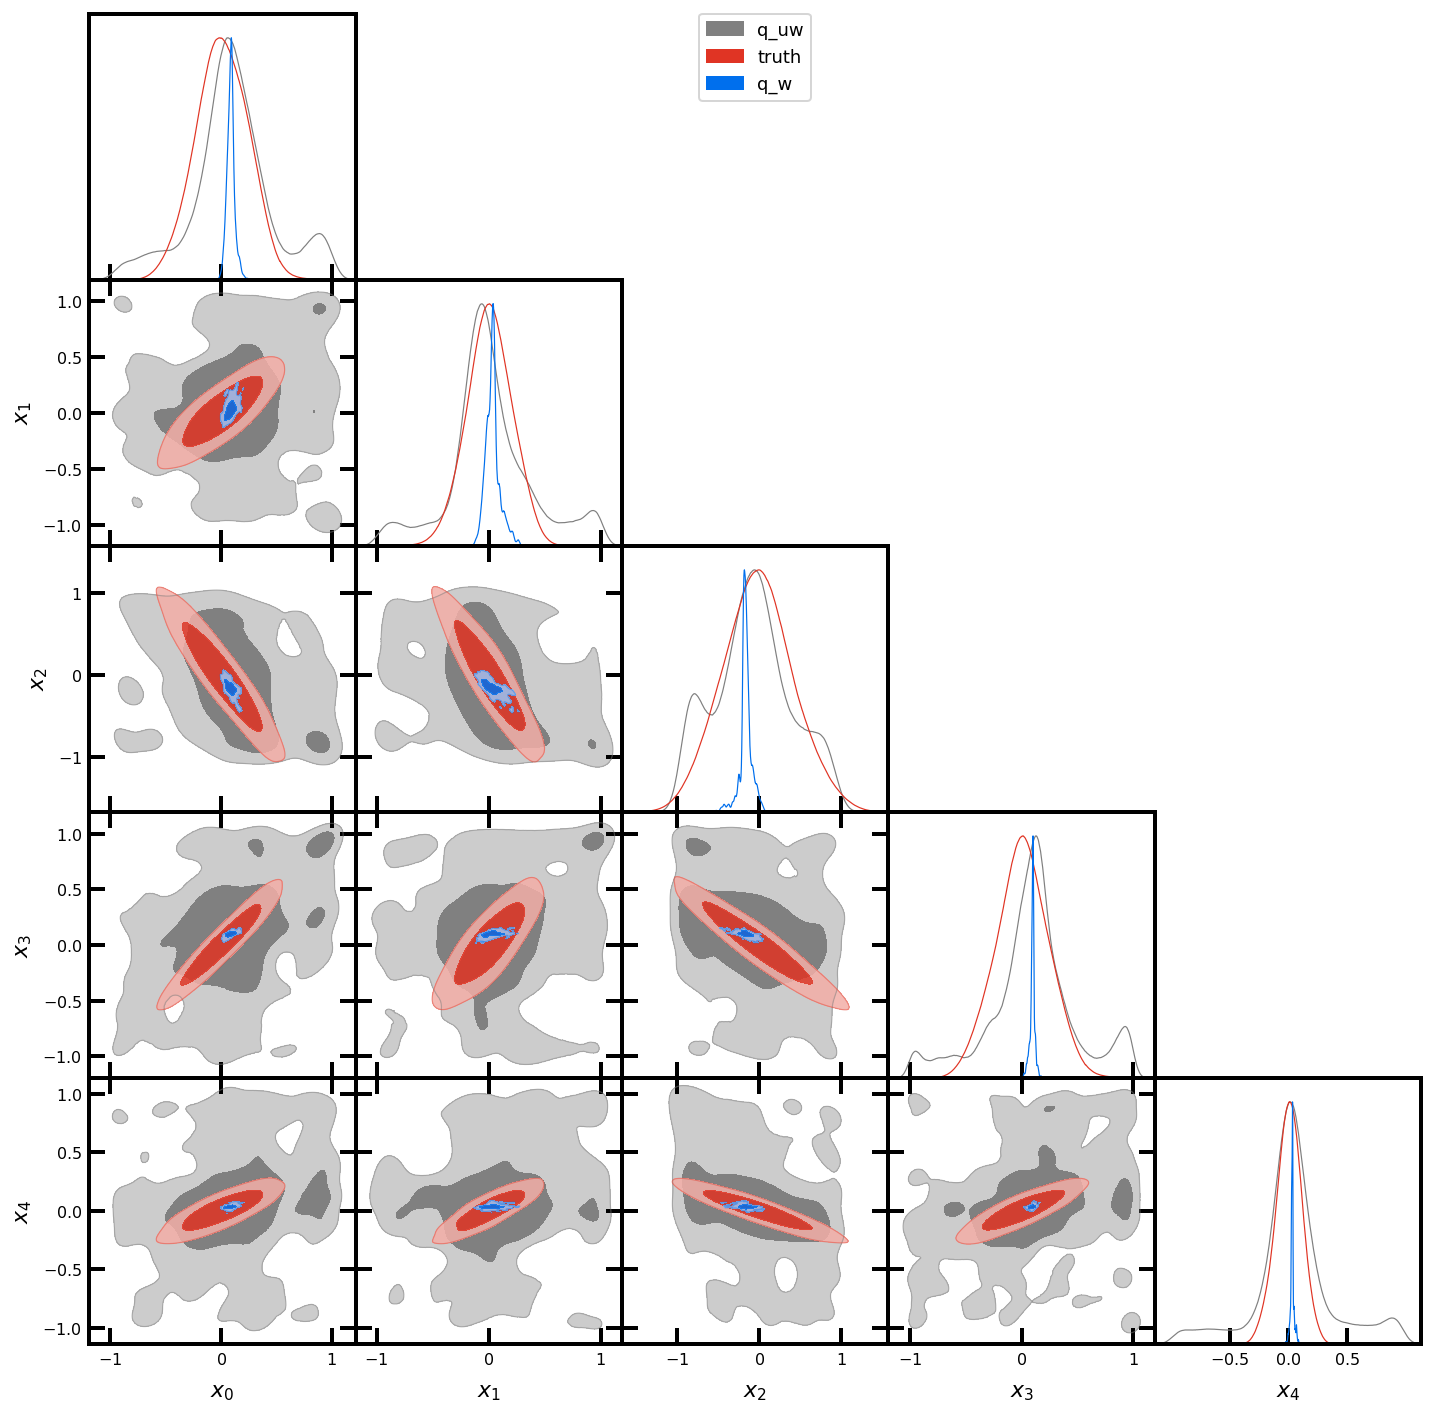

In [82]:
for t in vbe: plot_corr_gd(t,Cov)